In [1]:
from __future__ import division, unicode_literals, print_function  # for compatibility with Python 2 and 3

import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit

# import importlib
# import utils
# importlib.reload(utils)

# change the following to %matplotlib notebook for interactive plotting
%matplotlib inline

# Optionally, tweak styles.
mpl.rc('figure',  figsize=(10, 5))
mpl.rc('image', cmap='gray')

In [2]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series  # for convenience

import pims
import trackpy as tp
import cv2
import scipy
from tqdm import tqdm

import skimage.io as io
import os

In [3]:
import pickle
import sys

In [4]:
sys.path.append('/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/')

In [51]:
import importlib
import utils
importlib.reload(utils)

<module 'utils' from '/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py'>

# Read in data and trace particle positions

In [6]:
# read the image stack
foldername='/Volumes/maxone/20231012/0p5low_alg_12p5mM_3000ul_100um_20231012_102823_PM/'
imgname='0p5low_alg_12p5mM_3000ul_100um_20231012_102625_PM_20231012_102823_PM'
img_tif = io.imread(foldername+imgname+'.tif')

In [7]:
framerate=5647

In [20]:
scale_px=74/100 #px/um

In [9]:
ref=img_tif[6066]

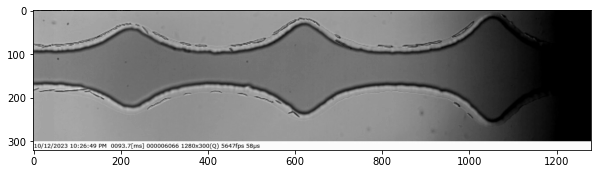

In [10]:
plt.imshow(ref)

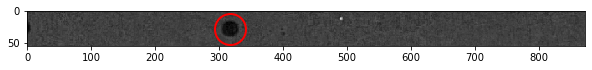

<AxesSubplot:>

In [11]:
crop_ys=105
crop_ye=160

crop_xs=0
crop_xe=873

frame=21
size=31
target=img_tif[frame,crop_ys:crop_ye,crop_xs:crop_xe]-ref[crop_ys:crop_ye,crop_xs:crop_xe]+100
f_locate = tp.locate(target, size, minmass=1500, invert=True)
tp.annotate(f_locate, target, plot_style={'markersize': size})

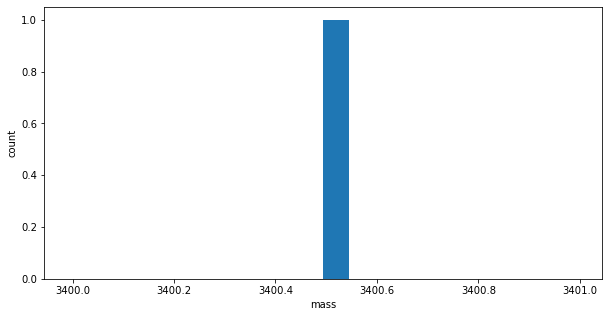

In [12]:
fig, ax = plt.subplots()
ax.hist(f_locate['mass'], bins=20)

# Optionally, label the axes.
ax.set(xlabel='mass', ylabel='count');

In [13]:
start_frame=0
end_frame=7000


In [14]:
img_tif.shape

(7000, 320, 1280)

In [90]:
with tp.PandasHDFStore(imgname+'.h5') as s:
    tp.batch(img_tif[start_frame:end_frame,crop_ys:crop_ye,crop_xs:crop_xe]-ref[crop_ys:crop_ye,crop_xs:crop_xe]+100,size, minmass=1500, invert=True, processes=1,output=s)

Frame 6999: 0 features


In [91]:
with tp.PandasHDFStore(imgname+'.h5') as s:
    # As before, we require a minimum "life" of 5 frames and a memory of 3 frames
    for linked in tp.link_df_iter(s, 100, memory=0,link_strategy='hybrid'):
        s.put(linked)

Frame 6876: 1 trajectories present.


In [15]:
with tp.PandasHDFStore(imgname+'.h5') as s:
    t = pd.concat(iter(s))

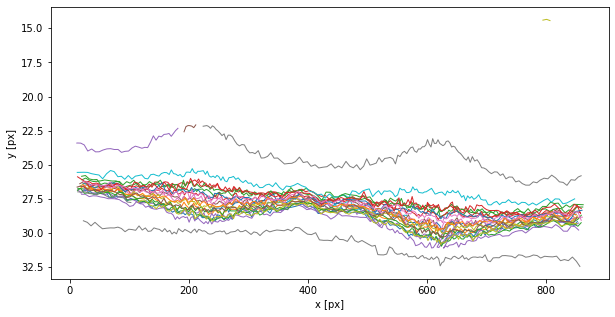

<AxesSubplot:xlabel='x [px]', ylabel='y [px]'>

In [16]:
plt.figure()
tp.plot_traj(t)

In [17]:
t1 = tp.filter_stubs(t, 70)
# Compare the number of particles in the unfiltered and filtered data.
print('Before:', t['particle'].nunique())
print('After:', t1['particle'].nunique())

Before: 39
After: 23


In [18]:
t1_modified = t1.copy()
t1_modified['y'] = t1['y'] + crop_ys
t1_modified['x'] = t1['x'] + crop_xs
t1_modified['frame'] = t1['frame']+start_frame

In [19]:
t1_modified['particle'].unique()

array([ 0,  1,  2,  3,  7,  9, 10, 12, 14, 22, 23, 24, 25, 26, 27, 28, 30,
       31, 32, 33, 35, 36, 38])

Text(0.5, 0, 's')

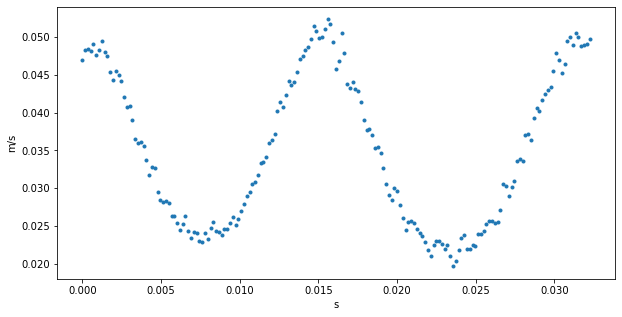

In [22]:
dt=1/framerate #s

x_pos=t1_modified[(t1_modified['particle'] == 1)]['x']
scale=10**(-6)/scale #um/px
v=np.gradient(x_pos,dt)*scale

# velocity in the middle of the channel
plt.plot(np.arange(0,len(x_pos))*dt,v,'.')
plt.ylabel('m/s')
plt.xlabel('s')

# Trace Particle Deformations

## some functions

## velocity and stress field
for one single beads
- sanity check for edge detection and fitting algorithm
- this beads gives the velocity and rescales for the stress field

In [23]:
t1_modified[t1_modified['particle']==1]

,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle
frame,,,,,,,,,,
25,131.729840,17.518246,4170.971688,8.193719,0.008156,13.424060,116928.0,0.026279,25,1
26,131.505018,23.683711,4223.710938,8.214328,0.009217,12.579117,116731.0,NaN,26,1
27,131.899823,30.194747,4375.385087,8.338352,0.033429,12.740202,117209.0,NaN,27,1
28,131.791355,36.384509,4254.912607,8.225847,0.025862,13.389511,116893.0,NaN,28,1
29,131.954704,42.811489,4345.716002,8.286538,0.021248,12.430817,117149.0,NaN,29,1
...,...,...,...,...,...,...,...,...,...,...
203,134.106546,824.496194,3677.362122,8.109560,0.038895,12.300289,115783.0,NaN,203,1
204,134.143839,830.823517,3506.131696,8.066119,0.023218,10.779415,115507.0,NaN,204,1
205,134.387972,837.303499,3670.780058,8.104519,0.039511,11.269645,115757.0,NaN,205,1


In [24]:
yloc=131
xloc=36

roi=25
parts=img_tif[28][yloc-roi:yloc+roi,xloc-roi:xloc+roi]-ref[yloc-roi:yloc+roi,xloc-roi:xloc+roi]+100
blur_parts=cv2.GaussianBlur(parts,(7,7),3)

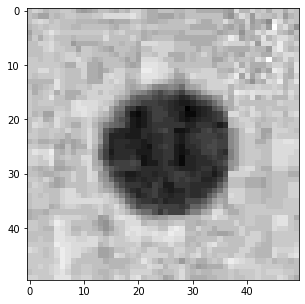

In [25]:
plt.imshow(parts)

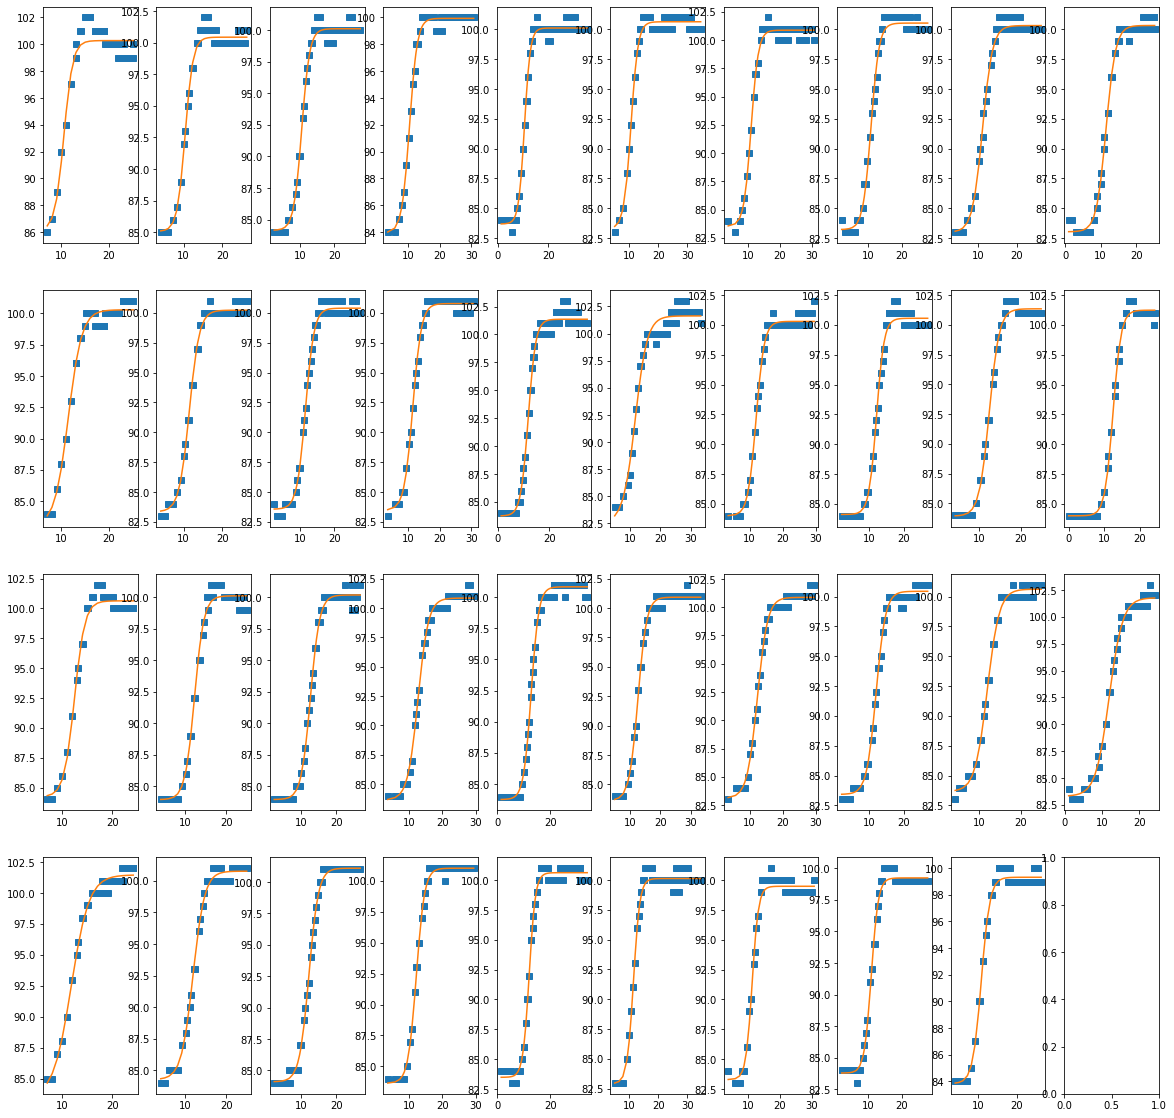

In [26]:
y_i, x_i=utils.detect_edge_sigmoid(blur_parts,roi,plot=True)

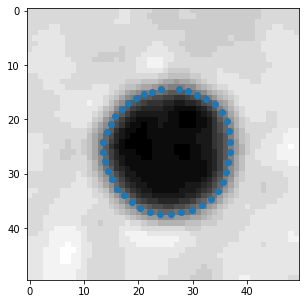

In [27]:
plt.imshow(blur_parts)
plt.plot(x_i,y_i,'o')

In [34]:
dire='/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/test/'
gamma_2 = utils.process_frames(img_tif,ref,t1_modified,1,dire)

frame number is25


error: OpenCV(4.8.0) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/smooth.dispatch.cpp:617: error: (-215:Assertion failed) !_src.empty() in function 'GaussianBlur'


### velocity

Text(0.5, 0, 's')

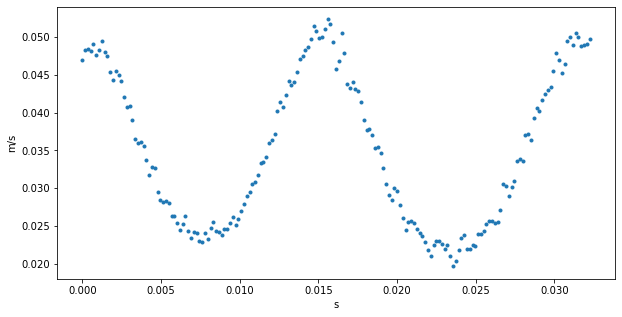

In [28]:
x_pos=t1_modified[(t1_modified['particle'] == 1)]['x']

v=np.gradient(x_pos,dt)*scale

# velocity in the middle of the channel
plt.plot(np.arange(0,len(x_pos))*dt,v,'.')
plt.ylabel('m/s')
plt.xlabel('s')

In [29]:
max_velocity=np.mean(sorted(v, reverse=True)[3:5])
print(max_velocity)

0.050971656449380245


### rescale for stress field

In [30]:
real_stress=utils.calculate_stress(max_velocity)
print('The real stess amplitude in this experiment is '+str(real_stress)+' Pa.')

Q is: 1786.0468419862834 ul/h
The real stess amplitude in this experiment is 6.207619589013808 Pa.


### fit for G' and G''

In [31]:
utils.calculate_modulus(framerate,gamma_2,real_stress)

NameError: name 'gamma_2' is not defined

# process all beads

## wavelength 1

In [35]:
wavelength1=t1_modified[(t1_modified['x'] >= 34) & (t1_modified['x'] <= 417)]

In [36]:
wavelength1['particle'].unique()

array([ 0,  1,  2,  3,  7,  9, 10, 12, 14, 22, 23, 24, 25, 26, 27, 28, 30,
       31, 32, 33, 35, 36, 38])

In [37]:
gamma2list_w1=utils.analyze_wavelength_gamma2(wavelength1,1,imgname,img_tif,ref)

particle number: 0
frame number is0
frame number is1
frame number is2
frame number is3
frame number is4
frame number is5


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6
frame number is7


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is8
frame number is9


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is10
frame number is11
frame number is12
frame number is13
frame number is14
frame number is15
frame number is16
frame number is17


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is18
frame number is19
frame number is20
frame number is21
frame number is22
frame number is23


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is24
frame number is25
frame number is26
frame number is27
frame number is28
frame number is29


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is30
frame number is31
frame number is32
frame number is33


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is34
frame number is35
frame number is36
frame number is37
particle number: 1
frame number is28
frame number is29
frame number is30
frame number is31
frame number is32
frame number is33
frame number is34
frame number is35
frame number is36
frame number is37
frame number is38
frame number is39
frame number is40


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is41
frame number is42
frame number is43
frame number is44
frame number is45
frame number is46
frame number is47
frame number is48
frame number is49
frame number is50
frame number is51
frame number is52
frame number is53
frame number is54
frame number is55
frame number is56


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is57
frame number is58


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is59
frame number is60
frame number is61
frame number is62
frame number is63
frame number is64
frame number is65
frame number is66
frame number is67
frame number is68
frame number is69
frame number is70
frame number is71
frame number is72
frame number is73
frame number is74
frame number is75
frame number is76
frame number is77
frame number is78


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is79
frame number is80


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is81
frame number is82
frame number is83
frame number is84
frame number is85


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is86
frame number is87
frame number is88
frame number is89
frame number is90
frame number is91


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is92
frame number is93
frame number is94
frame number is95


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is96
frame number is97
frame number is98
frame number is99
frame number is100
frame number is101
frame number is102
frame number is103


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is104
frame number is105
frame number is106
frame number is107


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is108
frame number is109
frame number is110
particle number: 2
frame number is711
frame number is712
frame number is713


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is714
frame number is715
frame number is716
frame number is717
frame number is718
frame number is719
frame number is720
frame number is721
frame number is722


/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is723
frame number is724
frame number is725
frame number is726
frame number is727
frame number is728
frame number is729
frame number is730
frame number is731
frame number is732


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is733
frame number is734


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is735
frame number is736


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is737
frame number is738


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is739
frame number is740
frame number is741
frame number is742
frame number is743
frame number is744


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is745
frame number is746


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is747
frame number is748
frame number is749
frame number is750
frame number is751
frame number is752


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is753
frame number is754
frame number is755
frame number is756
frame number is757
frame number is758
frame number is759
frame number is760
frame number is761
frame number is762


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is763
frame number is764
frame number is765
frame number is766


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is767
frame number is768
frame number is769
frame number is770


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is771
frame number is772
frame number is773
frame number is774


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is775
frame number is776
frame number is777
frame number is778


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is779
frame number is780
frame number is781
frame number is782
frame number is783
frame number is784


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is785
frame number is786
frame number is787
frame number is788
frame number is789
frame number is790
frame number is791
frame number is792
particle number: 3
frame number is1385
frame number is1386
frame number is1387
frame number is1388


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1389
frame number is1390
frame number is1391
frame number is1392
frame number is1393
frame number is1394


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1395
frame number is1396
frame number is1397
frame number is1398
frame number is1399
frame number is1400
frame number is1401
frame number is1402
frame number is1403
frame number is1404
frame number is1405
frame number is1406
frame number is1407
frame number is1408
frame number is1409
frame number is1410
frame number is1411
frame number is1412


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1413


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1414
frame number is1415
frame number is1416
frame number is1417


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1418
frame number is1419


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1420
frame number is1421


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1422
frame number is1423
frame number is1424
frame number is1425
frame number is1426
frame number is1427
frame number is1428
frame number is1429


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1430
frame number is1431
frame number is1432
frame number is1433
frame number is1434
frame number is1435
frame number is1436
frame number is1437
frame number is1438
frame number is1439
frame number is1440
frame number is1441


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1442
frame number is1443


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1444
frame number is1445
frame number is1446
frame number is1447
frame number is1448
frame number is1449
frame number is1450
frame number is1451


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1452
frame number is1453
frame number is1454
frame number is1455


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1456
frame number is1457
frame number is1458
frame number is1459


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1460
frame number is1461
frame number is1462
frame number is1463
frame number is1464
frame number is1465
frame number is1466
frame number is1467
particle number: 7
frame number is1464
frame number is1465


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1466
frame number is1467


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1468
frame number is1469
frame number is1470
frame number is1471
frame number is1472
frame number is1473
frame number is1474
frame number is1475


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1476
frame number is1477


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1478
frame number is1479


/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is1480


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1481
frame number is1482
frame number is1483
frame number is1484
frame number is1485
frame number is1486


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is1487
frame number is1488


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1489
frame number is1490
frame number is1491
frame number is1492


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is1493
frame number is1494


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1495
frame number is1496
frame number is1497
frame number is1498


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1499
frame number is1500


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1501
frame number is1502


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1503
frame number is1504
frame number is1505
particle number: 9
frame number is1644
frame number is1645
frame number is1646


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1647
frame number is1648
frame number is1649
frame number is1650
frame number is1651
frame number is1652
frame number is1653
frame number is1654
frame number is1655
frame number is1656
frame number is1657
frame number is1658
frame number is1659
frame number is1660


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1661
frame number is1662
frame number is1663
frame number is1664


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1665
frame number is1666


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1667
frame number is1668


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1669
frame number is1670
frame number is1671
frame number is1672
frame number is1673
frame number is1674
frame number is1675
frame number is1676
frame number is1677
frame number is1678
frame number is1679
frame number is1680


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1681
frame number is1682
frame number is1683
frame number is1684


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1685
frame number is1686
frame number is1687
frame number is1688
frame number is1689
frame number is1690
frame number is1691
frame number is1692


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1693
frame number is1694
frame number is1695
frame number is1696


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1697
frame number is1698
frame number is1699
frame number is1700
frame number is1701
frame number is1702
frame number is1703
frame number is1704
frame number is1705
frame number is1706
frame number is1707


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1708
frame number is1709
frame number is1710
frame number is1711


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1712
frame number is1713


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1714
frame number is1715
frame number is1716
frame number is1717
frame number is1718
frame number is1719
frame number is1720
frame number is1721
frame number is1722
frame number is1723
frame number is1724
frame number is1725


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1726
particle number: 10
frame number is1659


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1660
frame number is1661
frame number is1662
frame number is1663
frame number is1664
frame number is1665
frame number is1666
frame number is1667


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1668
frame number is1669
frame number is1670
frame number is1671
frame number is1672
frame number is1673
frame number is1674
frame number is1675


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1676
frame number is1677
frame number is1678
frame number is1679


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1680
frame number is1681
frame number is1682
frame number is1683
frame number is1684
frame number is1685


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1686
frame number is1687
frame number is1688
frame number is1689
frame number is1690
frame number is1691
frame number is1692
frame number is1693
frame number is1694
frame number is1695
frame number is1696
frame number is1697
frame number is1698
frame number is1699


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1700
frame number is1701


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1702
frame number is1703
frame number is1704
frame number is1705
frame number is1706
frame number is1707
frame number is1708
frame number is1709


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1710
frame number is1711
frame number is1712
frame number is1713
frame number is1714
frame number is1715
frame number is1716
frame number is1717
frame number is1718
frame number is1719
frame number is1720
frame number is1721
frame number is1722
frame number is1723
frame number is1724
frame number is1725


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1726
frame number is1727
frame number is1728
frame number is1729


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1730
frame number is1731
frame number is1732
frame number is1733
frame number is1734
frame number is1735
frame number is1736
frame number is1737


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1738
frame number is1739


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1740
particle number: 12
frame number is1710
frame number is1711
frame number is1712
frame number is1713
frame number is1714
frame number is1715
frame number is1716


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1717
frame number is1718


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1719
frame number is1720
frame number is1721
frame number is1722
frame number is1723
frame number is1724
frame number is1725
frame number is1726


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1727
frame number is1728
frame number is1729
frame number is1730
frame number is1731
frame number is1732
frame number is1733
frame number is1734


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1735
frame number is1736
frame number is1737
frame number is1738


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1739
frame number is1740
frame number is1741
frame number is1742
frame number is1743
frame number is1744
frame number is1745
frame number is1746


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1747
frame number is1748
frame number is1749
frame number is1750
frame number is1751
frame number is1752
frame number is1753
frame number is1754
frame number is1755
frame number is1756
frame number is1757
frame number is1758
frame number is1759
frame number is1760


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1761
frame number is1762


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1763
frame number is1764


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1765
frame number is1766


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1767
frame number is1768
frame number is1769
frame number is1770


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1771
frame number is1772
frame number is1773
frame number is1774
frame number is1775
frame number is1776


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1777
frame number is1778


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1779
frame number is1780
frame number is1781
frame number is1782


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1783
frame number is1784


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is1785
frame number is1786


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1787
frame number is1788


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1789
frame number is1790
frame number is1791
particle number: 14
frame number is2556


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2557
frame number is2558
frame number is2559
frame number is2560
frame number is2561
frame number is2562


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2563
frame number is2564
frame number is2565
frame number is2566
frame number is2567
frame number is2568
frame number is2569
frame number is2570
frame number is2571
frame number is2572


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is2573
frame number is2574


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2575
frame number is2576


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is2577
frame number is2578


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2579
frame number is2580


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is2581
frame number is2582
frame number is2583
frame number is2584


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2585
frame number is2586


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is2587
frame number is2588


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2589
frame number is2590
frame number is2591
frame number is2592
frame number is2593
frame number is2594


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2595
frame number is2596
frame number is2597
frame number is2598
frame number is2599
frame number is2600


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is2601
frame number is2602


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is2603
frame number is2604
frame number is2605
frame number is2606


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is2607
frame number is2608
frame number is2609
frame number is2610


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2611
frame number is2612
frame number is2613
frame number is2614
frame number is2615
frame number is2616
frame number is2617
frame number is2618
frame number is2619
frame number is2620


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2621
frame number is2622
frame number is2623
frame number is2624
frame number is2625
frame number is2626
frame number is2627
frame number is2628


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2629
frame number is2630
frame number is2631
frame number is2632


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2633
frame number is2634
frame number is2635
frame number is2636
frame number is2637
particle number: 22
frame number is2925


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2926
frame number is2927
frame number is2928
frame number is2929
frame number is2930
frame number is2931
frame number is2932
frame number is2933


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is2934
frame number is2935
frame number is2936
frame number is2937


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2938
frame number is2939


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2940
frame number is2941
frame number is2942
frame number is2943
frame number is2944
frame number is2945
frame number is2946
frame number is2947
frame number is2948
frame number is2949
frame number is2950
frame number is2951
frame number is2952
frame number is2953
frame number is2954
frame number is2955


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2956
frame number is2957
frame number is2958
frame number is2959
frame number is2960
frame number is2961
frame number is2962
frame number is2963
frame number is2964
frame number is2965
frame number is2966
frame number is2967
frame number is2968
frame number is2969
frame number is2970
frame number is2971
frame number is2972
frame number is2973
frame number is2974
frame number is2975
frame number is2976
frame number is2977


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2978
frame number is2979
frame number is2980
frame number is2981
frame number is2982
frame number is2983
frame number is2984
frame number is2985
frame number is2986
frame number is2987
frame number is2988
frame number is2989
frame number is2990
frame number is2991
frame number is2992
frame number is2993


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2994
frame number is2995


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2996
frame number is2997
frame number is2998
frame number is2999
frame number is3000
frame number is3001
frame number is3002
frame number is3003


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3004
frame number is3005
particle number: 23
frame number is3855
frame number is3856


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3857
frame number is3858
frame number is3859
frame number is3860


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3861
frame number is3862


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3863
frame number is3864
frame number is3865
frame number is3866
frame number is3867
frame number is3868
frame number is3869
frame number is3870
frame number is3871
frame number is3872


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3873
frame number is3874


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3875
frame number is3876
frame number is3877
frame number is3878
frame number is3879
frame number is3880
frame number is3881
frame number is3882
frame number is3883
frame number is3884
frame number is3885
frame number is3886


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3887
frame number is3888
frame number is3889
frame number is3890


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3891
frame number is3892
frame number is3893
frame number is3894


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3895
frame number is3896
frame number is3897
frame number is3898


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3899
frame number is3900


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3901
frame number is3902
frame number is3903
frame number is3904


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3905
frame number is3906


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is3907
frame number is3908
frame number is3909
frame number is3910


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3911
frame number is3912


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3913
frame number is3914
frame number is3915
frame number is3916
frame number is3917
frame number is3918


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3919
frame number is3920
frame number is3921
frame number is3922
frame number is3923
frame number is3924
frame number is3925


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3926
frame number is3927
frame number is3928
frame number is3929
frame number is3930
frame number is3931
frame number is3932
frame number is3933
frame number is3934
frame number is3935


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3936
particle number: 24
frame number is5019
frame number is5020
frame number is5021


/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5022
frame number is5023
frame number is5024
frame number is5025


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is5026
frame number is5027
frame number is5028
frame number is5029
frame number is5030
frame number is5031


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5032
frame number is5033
frame number is5034
frame number is5035
frame number is5036
frame number is5037
frame number is5038
frame number is5039
frame number is5040
frame number is5041


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5042
frame number is5043
frame number is5044
frame number is5045


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5046
frame number is5047
frame number is5048
frame number is5049
frame number is5050
frame number is5051
frame number is5052
frame number is5053
frame number is5054
frame number is5055


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5056
frame number is5057


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5058
frame number is5059


/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is5060
frame number is5061
frame number is5062
frame number is5063
frame number is5064
frame number is5065
frame number is5066
frame number is5067
frame number is5068
frame number is5069
frame number is5070
frame number is5071
frame number is5072
frame number is5073


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5074
frame number is5075
frame number is5076
frame number is5077
frame number is5078
frame number is5079
frame number is5080
frame number is5081
frame number is5082
frame number is5083
frame number is5084
frame number is5085
frame number is5086
frame number is5087


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5088
frame number is5089
frame number is5090
frame number is5091


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5092
frame number is5093


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5094
frame number is5095
frame number is5096
frame number is5097
frame number is5098
frame number is5099
particle number: 25
frame number is5039
frame number is5040


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5041
frame number is5042
frame number is5043
frame number is5044
frame number is5045
frame number is5046
frame number is5047
frame number is5048
frame number is5049
frame number is5050


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5051
frame number is5052
frame number is5053
frame number is5054
frame number is5055
frame number is5056
frame number is5057
frame number is5058


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5059
frame number is5060
frame number is5061
frame number is5062
frame number is5063
frame number is5064


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5065
frame number is5066
frame number is5067
frame number is5068
frame number is5069
frame number is5070
frame number is5071
frame number is5072


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5073
frame number is5074
frame number is5075
frame number is5076
frame number is5077
frame number is5078
frame number is5079
frame number is5080
frame number is5081
frame number is5082
frame number is5083
frame number is5084
frame number is5085
frame number is5086
frame number is5087
frame number is5088
frame number is5089
frame number is5090
frame number is5091
frame number is5092


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5093
frame number is5094
frame number is5095
frame number is5096
frame number is5097
frame number is5098
frame number is5099
frame number is5100
frame number is5101
frame number is5102


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5103
frame number is5104


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5105
frame number is5106
frame number is5107
frame number is5108
frame number is5109
frame number is5110
frame number is5111
frame number is5112
frame number is5113
frame number is5114
frame number is5115
frame number is5116
frame number is5117
frame number is5118
frame number is5119
particle number: 26
frame number is5054
frame number is5055
frame number is5056


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5057
frame number is5058
frame number is5059
frame number is5060
frame number is5061
frame number is5062
frame number is5063
frame number is5064
frame number is5065
frame number is5066


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5067
frame number is5068
frame number is5069
frame number is5070
frame number is5071
frame number is5072
frame number is5073
frame number is5074


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5075
frame number is5076
frame number is5077
frame number is5078
frame number is5079
frame number is5080
frame number is5081
frame number is5082
frame number is5083
frame number is5084
frame number is5085
frame number is5086


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5087
frame number is5088
frame number is5089
frame number is5090


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5091
frame number is5092
frame number is5093
frame number is5094
frame number is5095
frame number is5096
frame number is5097
frame number is5098


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is5099
frame number is5100
frame number is5101
frame number is5102
frame number is5103
frame number is5104
frame number is5105
frame number is5106


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5107
frame number is5108
frame number is5109
frame number is5110
frame number is5111
frame number is5112
frame number is5113
frame number is5114


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5115
frame number is5116
frame number is5117
frame number is5118
frame number is5119
frame number is5120


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5121
frame number is5122


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5123
frame number is5124
frame number is5125
frame number is5126
frame number is5127
frame number is5128
frame number is5129
frame number is5130
frame number is5131
frame number is5132
frame number is5133
frame number is5134


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


particle number: 27
frame number is5326
frame number is5327
frame number is5328
frame number is5329


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5330
frame number is5331
frame number is5332
frame number is5333
frame number is5334
frame number is5335


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5336
frame number is5337


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5338
frame number is5339
frame number is5340
frame number is5341


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5342
frame number is5343
frame number is5344
frame number is5345


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5346
frame number is5347
frame number is5348
frame number is5349


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5350
frame number is5351
frame number is5352
frame number is5353


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5354
frame number is5355
frame number is5356
frame number is5357
frame number is5358
frame number is5359
frame number is5360
frame number is5361


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5362
frame number is5363


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5364
frame number is5365


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5366
frame number is5367
frame number is5368
frame number is5369


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5370
frame number is5371
frame number is5372
frame number is5373


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5374
frame number is5375
frame number is5376
frame number is5377


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5378
frame number is5379


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5380
frame number is5381


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5382
frame number is5383
frame number is5384
frame number is5385


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5386
frame number is5387


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5388
frame number is5389
frame number is5390
frame number is5391
frame number is5392
frame number is5393


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5394
frame number is5395


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5396
frame number is5397


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5398
frame number is5399
frame number is5400
frame number is5401


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5402
frame number is5403


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5404
frame number is5405
frame number is5406
particle number: 28
frame number is5738


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5739
frame number is5740
frame number is5741
frame number is5742
frame number is5743
frame number is5744
frame number is5745
frame number is5746


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5747
frame number is5748


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5749
frame number is5750


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5751
frame number is5752
frame number is5753
frame number is5754
frame number is5755
frame number is5756


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5757
frame number is5758
frame number is5759
frame number is5760


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5761
frame number is5762


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5763
frame number is5764
frame number is5765
frame number is5766
frame number is5767
frame number is5768
frame number is5769
frame number is5770
frame number is5771
frame number is5772


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5773
frame number is5774
frame number is5775
frame number is5776
frame number is5777
frame number is5778
frame number is5779
frame number is5780
frame number is5781
frame number is5782


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5783
frame number is5784
frame number is5785
frame number is5786
frame number is5787
frame number is5788
frame number is5789
frame number is5790


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5791
frame number is5792
frame number is5793
frame number is5794
frame number is5795
frame number is5796


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5797
frame number is5798
frame number is5799
frame number is5800
frame number is5801
frame number is5802
frame number is5803
frame number is5804


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5805
frame number is5806
frame number is5807
frame number is5808
frame number is5809
frame number is5810
frame number is5811
frame number is5812
frame number is5813
frame number is5814
frame number is5815
frame number is5816
frame number is5817
particle number: 30
frame number is5756
frame number is5757
frame number is5758
frame number is5759
frame number is5760
frame number is5761
frame number is5762


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5763
frame number is5764
frame number is5765
frame number is5766
frame number is5767
frame number is5768
frame number is5769
frame number is5770
frame number is5771
frame number is5772
frame number is5773
frame number is5774
frame number is5775
frame number is5776
frame number is5777
frame number is5778


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5779
frame number is5780


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5781
frame number is5782
frame number is5783
frame number is5784


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5785
frame number is5786


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5787
frame number is5788


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5789
frame number is5790
frame number is5791
frame number is5792


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5793
frame number is5794
frame number is5795
frame number is5796
frame number is5797
frame number is5798


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5799
frame number is5800
frame number is5801
frame number is5802
frame number is5803


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5804
frame number is5805
frame number is5806
frame number is5807


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5808
frame number is5809
frame number is5810
frame number is5811
frame number is5812
frame number is5813


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5814
frame number is5815
frame number is5816
frame number is5817
frame number is5818
frame number is5819
frame number is5820
frame number is5821
frame number is5822
frame number is5823


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5824
frame number is5825
frame number is5826
frame number is5827


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5828
frame number is5829
frame number is5830
frame number is5831
frame number is5832
frame number is5833
frame number is5834
frame number is5835


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5836
particle number: 31
frame number is6217
frame number is6218
frame number is6219
frame number is6220
frame number is6221


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6222
frame number is6223
frame number is6224
frame number is6225
frame number is6226
frame number is6227
frame number is6228
frame number is6229
frame number is6230
frame number is6231
frame number is6232
frame number is6233


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6234
frame number is6235


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6236
frame number is6237
frame number is6238
frame number is6239
frame number is6240
frame number is6241


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6242
frame number is6243
frame number is6244
frame number is6245


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6246
frame number is6247
frame number is6248
frame number is6249
frame number is6250
frame number is6251


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6252
frame number is6253


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6254
frame number is6255
frame number is6256
frame number is6257
frame number is6258
frame number is6259
frame number is6260
frame number is6261
frame number is6262
frame number is6263
frame number is6264
frame number is6265
frame number is6266
frame number is6267
frame number is6268
frame number is6269
frame number is6270
frame number is6271
frame number is6272
frame number is6273


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6274
frame number is6275
frame number is6276
frame number is6277


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6278
frame number is6279
frame number is6280
frame number is6281
frame number is6282
frame number is6283
frame number is6284
frame number is6285


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6286
frame number is6287
frame number is6288
frame number is6289
frame number is6290
frame number is6291
frame number is6292
frame number is6293


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6294
frame number is6295
frame number is6296
frame number is6297


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


particle number: 32
frame number is6253
frame number is6254
frame number is6255
frame number is6256
frame number is6257
frame number is6258


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6259
frame number is6260
frame number is6261
frame number is6262


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6263
frame number is6264
frame number is6265
frame number is6266
frame number is6267
frame number is6268


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6269
frame number is6270
frame number is6271
frame number is6272
frame number is6273
frame number is6274
frame number is6275
frame number is6276
frame number is6277
frame number is6278
frame number is6279
frame number is6280
frame number is6281
frame number is6282


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6283
frame number is6284
frame number is6285
frame number is6286
frame number is6287
frame number is6288


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6289
frame number is6290


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6291
frame number is6292
frame number is6293
frame number is6294


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6295
frame number is6296
frame number is6297
frame number is6298
frame number is6299
frame number is6300
frame number is6301
frame number is6302


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6303
frame number is6304
frame number is6305
frame number is6306


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6307
frame number is6308
frame number is6309
frame number is6310
frame number is6311
frame number is6312
frame number is6313
frame number is6314
frame number is6315
frame number is6316
frame number is6317
frame number is6318
frame number is6319
frame number is6320
frame number is6321
frame number is6322
frame number is6323
frame number is6324


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6325
frame number is6326
frame number is6327
frame number is6328
frame number is6329
frame number is6330


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6331
frame number is6332
particle number: 33
frame number is6297
frame number is6298


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6299
frame number is6300
frame number is6301
frame number is6302
frame number is6303
frame number is6304
frame number is6305
frame number is6306


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6307
frame number is6308
frame number is6309
frame number is6310
frame number is6311
frame number is6312


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6313
frame number is6314
frame number is6315
frame number is6316


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6317
frame number is6318


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6319
frame number is6320
frame number is6321
frame number is6322
frame number is6323
frame number is6324


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6325
frame number is6326
frame number is6327
frame number is6328


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is6329
frame number is6330
frame number is6331
frame number is6332
frame number is6333
frame number is6334


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6335
frame number is6336
frame number is6337
frame number is6338
frame number is6339
frame number is6340
frame number is6341
frame number is6342
frame number is6343
frame number is6344


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6345
frame number is6346
frame number is6347
frame number is6348


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6349
frame number is6350
frame number is6351
frame number is6352
frame number is6353
frame number is6354


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6355
frame number is6356


/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6357
frame number is6358
frame number is6359
frame number is6360
frame number is6361
frame number is6362
frame number is6363
frame number is6364


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6365
frame number is6366
frame number is6367
frame number is6368
frame number is6369
frame number is6370
frame number is6371
frame number is6372
frame number is6373
frame number is6374
frame number is6375
frame number is6376


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6377
particle number: 35
frame number is6657
frame number is6658
frame number is6659
frame number is6660
frame number is6661
frame number is6662
frame number is6663
frame number is6664
frame number is6665
frame number is6666
frame number is6667
frame number is6668
frame number is6669
frame number is6670
frame number is6671


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6672
frame number is6673


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6674
frame number is6675


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6676
frame number is6677
frame number is6678
frame number is6679


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6680
frame number is6681
frame number is6682
frame number is6683


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6684
frame number is6685
frame number is6686
frame number is6687
frame number is6688
frame number is6689


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6690
frame number is6691
frame number is6692
frame number is6693
frame number is6694
frame number is6695
frame number is6696
frame number is6697


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6698
frame number is6699
frame number is6700
frame number is6701


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6702
frame number is6703
frame number is6704
frame number is6705
frame number is6706
frame number is6707
frame number is6708
frame number is6709
frame number is6710


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6711
frame number is6712
frame number is6713
frame number is6714


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6715
frame number is6716
frame number is6717
frame number is6718


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6719
frame number is6720
frame number is6721
frame number is6722


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6723
frame number is6724
frame number is6725
frame number is6726
frame number is6727
frame number is6728
frame number is6729
frame number is6730
frame number is6731
frame number is6732
frame number is6733
frame number is6734
frame number is6735
frame number is6736
particle number: 36
frame number is6671
frame number is6672
frame number is6673
frame number is6674


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6675
frame number is6676
frame number is6677
frame number is6678


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is6679
frame number is6680
frame number is6681
frame number is6682


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6683
frame number is6684
frame number is6685
frame number is6686
frame number is6687
frame number is6688
frame number is6689
frame number is6690
frame number is6691
frame number is6692


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6693
frame number is6694
frame number is6695
frame number is6696
frame number is6697
frame number is6698
frame number is6699
frame number is6700
frame number is6701
frame number is6702


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6703
frame number is6704
frame number is6705
frame number is6706


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6707
frame number is6708
frame number is6709
frame number is6710
frame number is6711
frame number is6712


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6713
frame number is6714
frame number is6715
frame number is6716
frame number is6717
frame number is6718
frame number is6719
frame number is6720
frame number is6721
frame number is6722
frame number is6723
frame number is6724


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6725
frame number is6726
frame number is6727
frame number is6728
frame number is6729
frame number is6730
frame number is6731
frame number is6732
frame number is6733
frame number is6734
frame number is6735
frame number is6736
frame number is6737
frame number is6738
frame number is6739
frame number is6740
frame number is6741
frame number is6742
frame number is6743
frame number is6744


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6745
frame number is6746
frame number is6747
frame number is6748
frame number is6749
frame number is6750
frame number is6751
particle number: 38
frame number is6716


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is6717
frame number is6718
frame number is6719
frame number is6720


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6721
frame number is6722
frame number is6723
frame number is6724
frame number is6725
frame number is6726


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6727
frame number is6728
frame number is6729
frame number is6730
frame number is6731
frame number is6732


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6733
frame number is6734
frame number is6735
frame number is6736
frame number is6737
frame number is6738
frame number is6739
frame number is6740


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6741
frame number is6742
frame number is6743
frame number is6744


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is6745
frame number is6746
frame number is6747
frame number is6748


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6749
frame number is6750
frame number is6751
frame number is6752
frame number is6753
frame number is6754
frame number is6755
frame number is6756
frame number is6757
frame number is6758
frame number is6759
frame number is6760
frame number is6761
frame number is6762
frame number is6763
frame number is6764


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6765
frame number is6766
frame number is6767
frame number is6768
frame number is6769
frame number is6770


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6771
frame number is6772
frame number is6773
frame number is6774
frame number is6775
frame number is6776
frame number is6777
frame number is6778
frame number is6779
frame number is6780


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6781
frame number is6782
frame number is6783


In [38]:
with open(imgname+'gamma2_w1.pkl', 'wb') as f:
    pickle.dump(gamma2list_w1, f)

In [31]:
with open(imgname+'gamma2_w1.pkl', "rb") as file:
    gamma2list_w1 = pickle.load(file)

particle is:0
933.7144060432402
Storage modulus is:713.7650121794505
Loss modulus is:3.169753402773925e-13
R^2: 0.11831646146890573
[0.00869701 3.14159265 0.02789428]


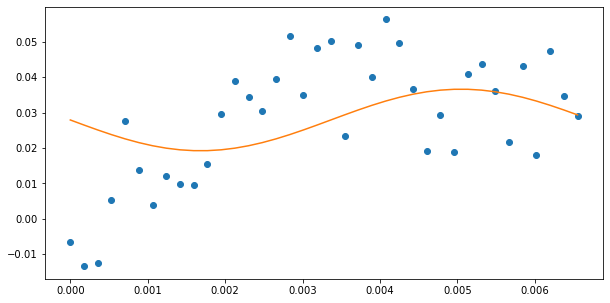

particle is:1
427.4837039716039
Storage modulus is:238.7533734918271
Loss modulus is:107.11023057080507
R^2: 0.6509247365707146
[ 2.37222904e-02  2.71988452e+00 -2.52029075e-03]


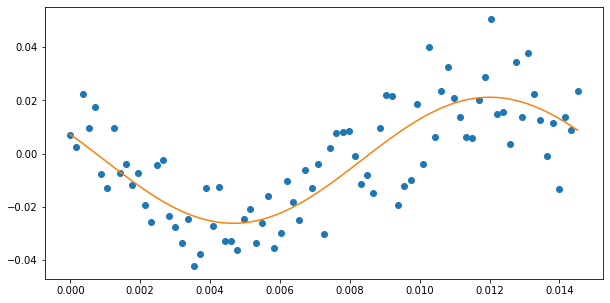

particle is:2
432.69691987369663
Storage modulus is:228.26646397313257
Loss modulus is:35.527852379772206
R^2: 0.7094158507458233
[2.68710983e-02 2.98718946e+00 1.92764391e-03]


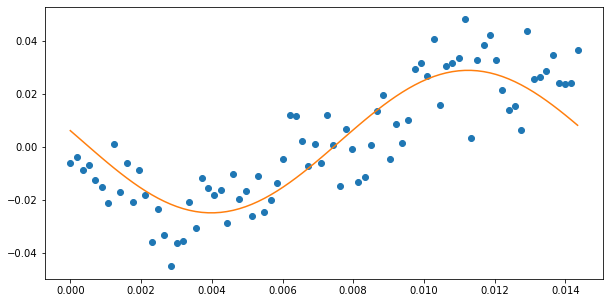

particle is:3
427.4837039716039
Storage modulus is:-64.36432643851101
Loss modulus is:200.19879966902553
R^2: 0.8146522049813505
[ 0.02951918  1.25973144 -0.0897042 ]


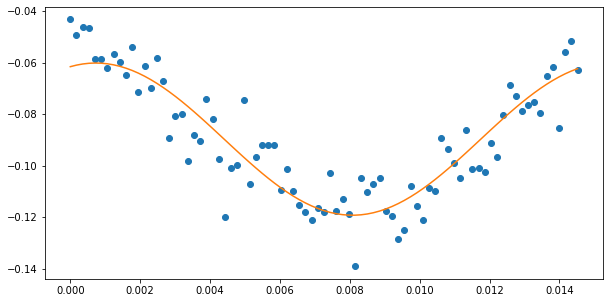

particle is:7
844.7892245153124
Storage modulus is:334.2826826197925
Loss modulus is:1.4845133239118292e-13
R^2: 0.49847132997675647
[0.01856997 3.14159265 0.03473602]


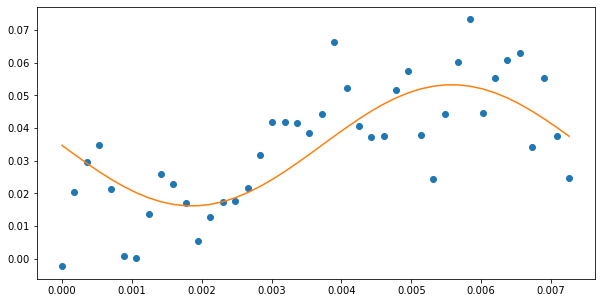

particle is:9
427.4837039716039
Storage modulus is:160.14972041618293
Loss modulus is:81.37718661965917
R^2: 0.8559246626291045
[ 3.45560747e-02  2.67146068e+00 -1.66523607e-03]


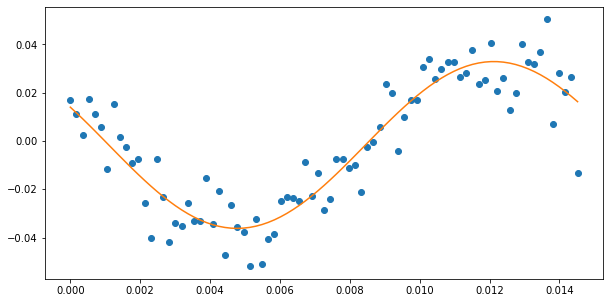

particle is:10
432.69691987369663
Storage modulus is:165.0217217575817
Loss modulus is:69.56440540897643
R^2: 0.8341994563931827
[ 3.46630125e-02  2.74265039e+00 -1.27286737e-03]


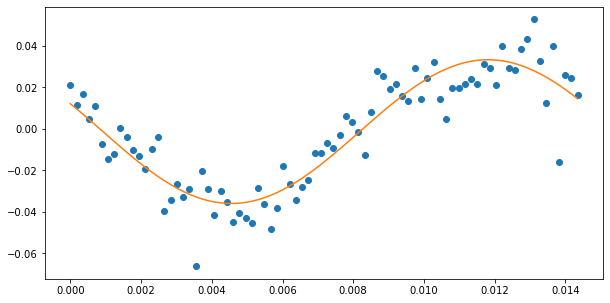

particle is:12
432.69691987369663
Storage modulus is:268.3918646214269
Loss modulus is:125.18069985133654
R^2: 0.5945172146265845
[0.02096112 2.70517613 0.00623442]


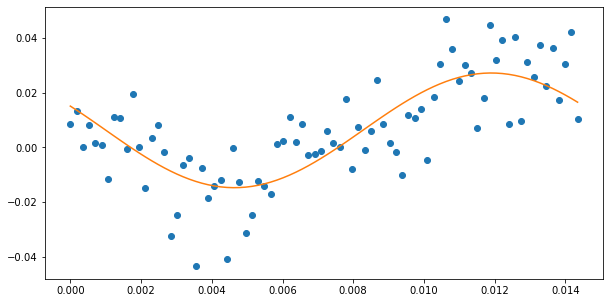

particle is:14
432.69691987369663
Storage modulus is:92.5096473517765
Loss modulus is:96.81699922992584
R^2: 0.8580052885112603
[ 0.04635707  2.33344751 -0.01629159]


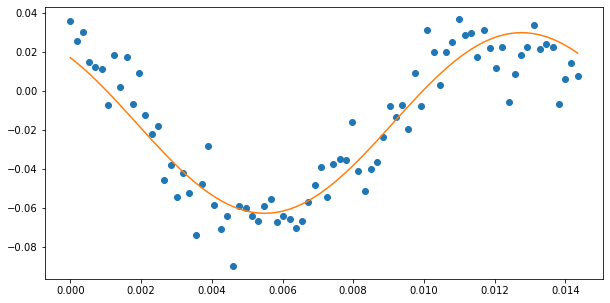

particle is:22
438.03885715608794
Storage modulus is:293.7342703180066
Loss modulus is:283.82995984270184
R^2: 0.4569012801989961
[0.01519763 2.37334122 0.03102427]


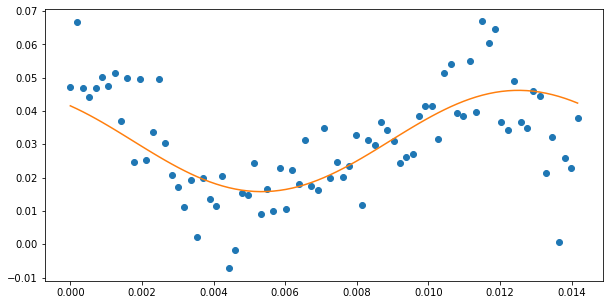

particle is:23
432.69691987369663
Storage modulus is:236.61319385522563
Loss modulus is:87.742701483432
R^2: 0.7646935081015711
[0.02459846 2.78648499 0.05730031]


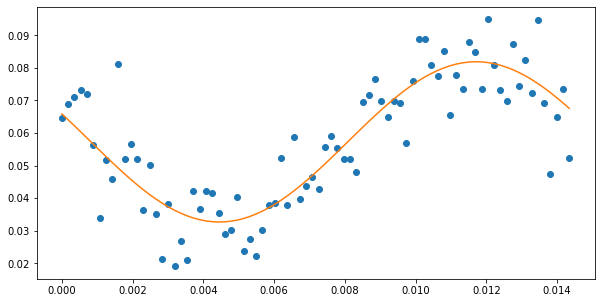

particle is:24
438.03885715608794
Storage modulus is:236.89423585592277
Loss modulus is:89.48704271228684
R^2: 0.7298700536730183
[0.0245135  2.7804123  0.00659544]


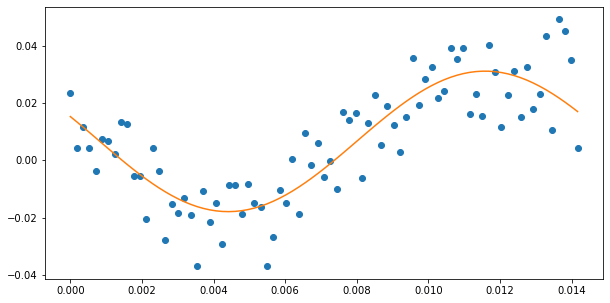

particle is:25
438.03885715608794
Storage modulus is:202.0522095481985
Loss modulus is:96.820550223543
R^2: 0.7993233885865175
[0.02770615 2.69473462 0.01718072]


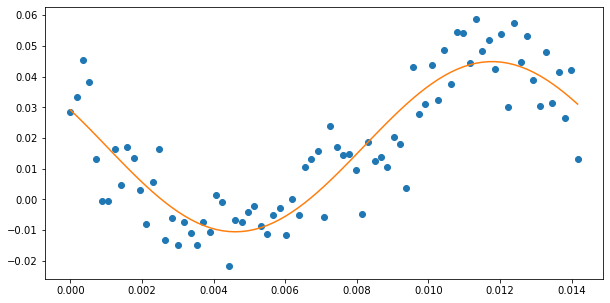

particle is:26
438.03885715608794
Storage modulus is:166.0851977317514
Loss modulus is:75.96801559501822
R^2: 0.8545645631409824
[0.03398927 2.71259874 0.00455805]


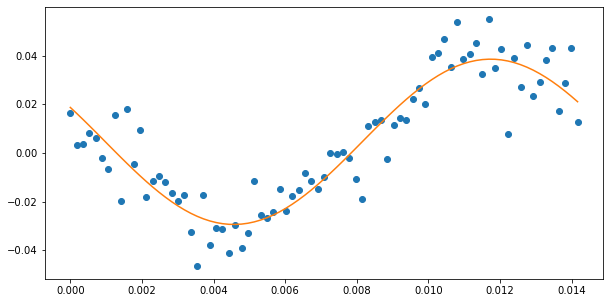

particle is:27
438.03885715608794
Storage modulus is:168.13185059653318
Loss modulus is:83.64011435627565
R^2: 0.8837349401190224
[ 0.03305669  2.67997318 -0.03631113]


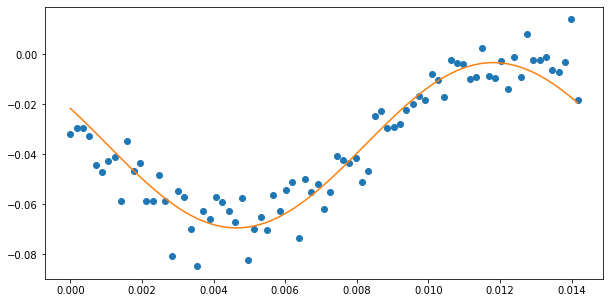

particle is:28
443.51434287053905
Storage modulus is:245.056684239459
Loss modulus is:146.36397310795746
R^2: 0.7133780775257617
[0.02174765 2.60318603 0.00447979]


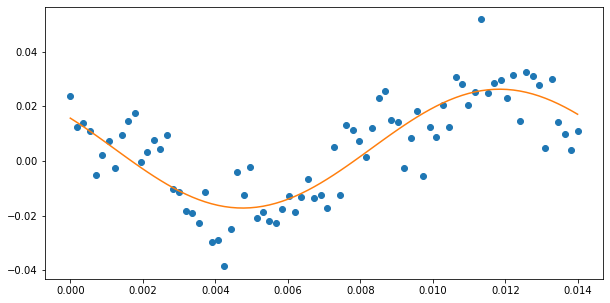

particle is:30
438.03885715608794
Storage modulus is:158.91891606639203
Loss modulus is:83.91668869643468
R^2: 0.8458204224063681
[ 0.0345416   2.65575986 -0.02147479]


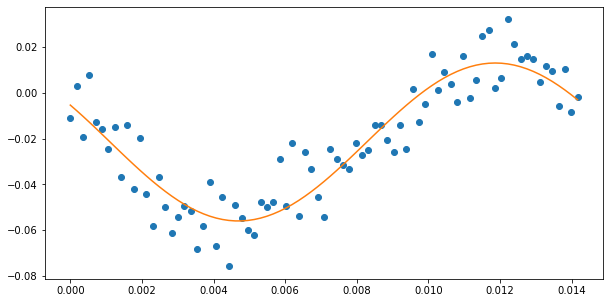

particle is:31
438.03885715608794
Storage modulus is:202.77164511869867
Loss modulus is:86.20838848375807
R^2: 0.7951847962362201
[2.81733448e-02 2.73959486e+00 1.22550487e-03]


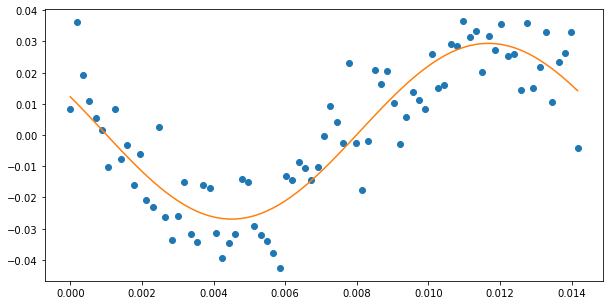

particle is:32
443.51434287053905
Storage modulus is:227.41310939998323
Loss modulus is:121.4763911220204
R^2: 0.7178872147929423
[ 0.02407696  2.65098714 -0.00464908]


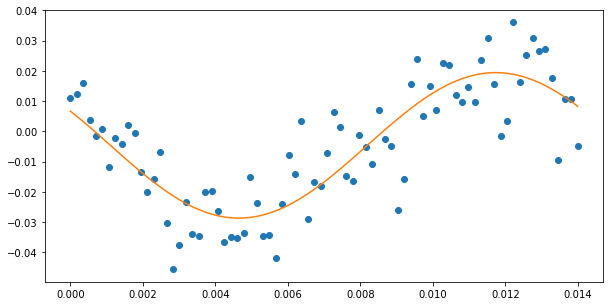

particle is:33
438.03885715608794
Storage modulus is:101.7484801128958
Loss modulus is:52.37001427651822
R^2: 0.9094384000948946
[ 0.05424581  2.66625377 -0.03008179]


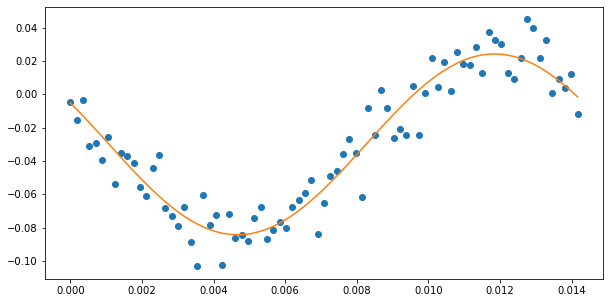

particle is:35
443.51434287053905
Storage modulus is:186.3292887056889
Loss modulus is:74.10728398021342
R^2: 0.7857688230898296
[ 0.03095675  2.76305149 -0.00339311]


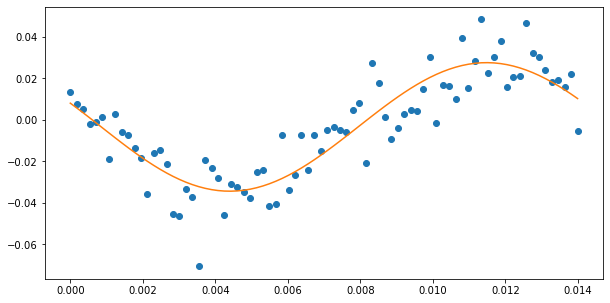

particle is:36
438.03885715608794
Storage modulus is:293.73025823914577
Loss modulus is:108.97346080494756
R^2: 0.5773716924165575
[ 0.01981408  2.78633483 -0.00727736]


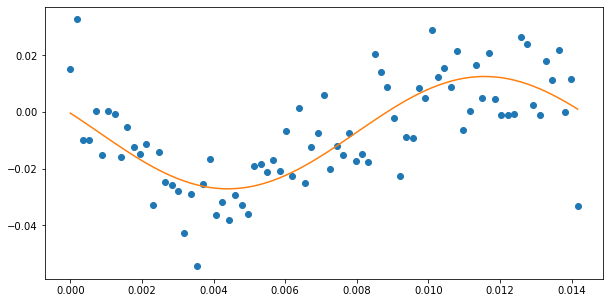

particle is:38
521.781579847693
Storage modulus is:259.01622338620933
Loss modulus is:1.1502630998192901e-13
R^2: 0.6515057463541873
[0.02396614 3.14159265 0.00642453]


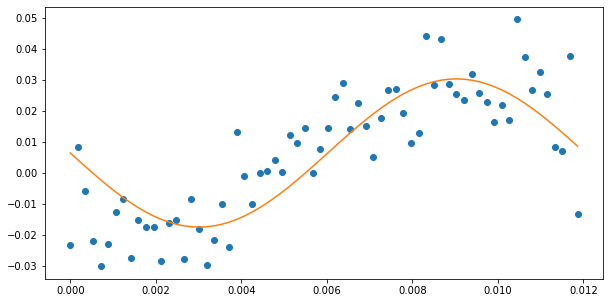

In [52]:
data1=utils.analyze_wavelength_modulus(wavelength1,gamma2list_w1,real_stress,framerate,imgname)

In [55]:
data1

,Droplet Number,Storage Modulus,Loss Modulus,Frequency,R^2,Video Name
5,9,160.149720,81.377187,427.483704,0.855925,0p5low_alg_12p5mM_3000ul_100um_20231012_102625...
6,10,165.021722,69.564405,432.696920,0.834199,0p5low_alg_12p5mM_3000ul_100um_20231012_102625...
8,14,92.509647,96.816999,432.696920,0.858005,0p5low_alg_12p5mM_3000ul_100um_20231012_102625...
10,23,236.613194,87.742701,432.696920,0.764694,0p5low_alg_12p5mM_3000ul_100um_20231012_102625...
12,25,202.052210,96.820550,438.038857,0.799323,0p5low_alg_12p5mM_3000ul_100um_20231012_102625...
13,26,166.085198,75.968016,438.038857,0.854565,0p5low_alg_12p5mM_3000ul_100um_20231012_102625...
14,27,168.131851,83.640114,438.038857,0.883735,0p5low_alg_12p5mM_3000ul_100um_20231012_102625...
16,30,158.918916,83.916689,438.038857,0.845820,0p5low_alg_12p5mM_3000ul_100um_20231012_102625...
17,31,202.771645,86.208388,438.038857,0.795185,0p5low_alg_12p5mM_3000ul_100um_20231012_102625...
19,33,101.748480,52.370014,438.038857,0.909438,0p5low_alg_12p5mM_3000ul_100um_20231012_102625...


In [54]:
data1 = data1[data1['Droplet Number'] != 3]

## wavelegnth 2

In [46]:
wavelength2=t1_modified[(t1_modified['x'] >= 417) & (t1_modified['x'] <= 829)]

In [47]:
gamma2list_w2=utils.analyze_wavelength_gamma2(wavelength2,2,imgname,img_tif,ref)

particle number: 0
frame number is38
frame number is39
frame number is40
frame number is41


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is42
frame number is43
frame number is44
frame number is45
frame number is46
frame number is47


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is48
frame number is49
frame number is50
frame number is51
frame number is52
frame number is53


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is54
frame number is55


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is56
frame number is57


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is58
frame number is59
frame number is60
frame number is61
frame number is62
frame number is63
frame number is64
frame number is65
frame number is66
frame number is67
frame number is68
frame number is69
frame number is70
frame number is71


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is72
frame number is73


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is74
frame number is75
frame number is76
frame number is77
frame number is78
frame number is79
frame number is80
frame number is81


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is82
frame number is83


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is84
frame number is85
frame number is86
frame number is87
frame number is88
frame number is89
frame number is90
frame number is91
frame number is92
frame number is93
frame number is94
frame number is95
frame number is96
frame number is97
frame number is98
frame number is99
frame number is100
frame number is101
frame number is102
frame number is103
frame number is104
frame number is105
frame number is106
frame number is107


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is108
frame number is109


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is110
frame number is111
frame number is112
frame number is113
frame number is114
frame number is115
frame number is116
frame number is117
frame number is118
frame number is119
frame number is120
frame number is121
frame number is122
frame number is123


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is124
frame number is125
frame number is126
frame number is127
frame number is128
frame number is129


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is130
particle number: 1
frame number is111
frame number is112
frame number is113
frame number is114
frame number is115
frame number is116
frame number is117
frame number is118
frame number is119
frame number is120
frame number is121


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is122
frame number is123


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is124
frame number is125
frame number is126
frame number is127
frame number is128
frame number is129


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is130
frame number is131
frame number is132
frame number is133
frame number is134
frame number is135
frame number is136
frame number is137


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is138
frame number is139
frame number is140
frame number is141


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is142
frame number is143
frame number is144
frame number is145
frame number is146
frame number is147
frame number is148
frame number is149


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is150
frame number is151
frame number is152
frame number is153
frame number is154
frame number is155
frame number is156
frame number is157


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is158
frame number is159


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is160
frame number is161


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is162
frame number is163


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is164
frame number is165
frame number is166
frame number is167
frame number is168
frame number is169


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is170
frame number is171
frame number is172
frame number is173
frame number is174
frame number is175
frame number is176
frame number is177
frame number is178
frame number is179


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is180
frame number is181


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is182
frame number is183
frame number is184
frame number is185
frame number is186
frame number is187
frame number is188
frame number is189


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is190
frame number is191
frame number is192
frame number is193
frame number is194
frame number is195
frame number is196
frame number is197
frame number is198
frame number is199
frame number is200
frame number is201


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is202
frame number is203
particle number: 2
frame number is793
frame number is794
frame number is795
frame number is796


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is797
frame number is798


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is799
frame number is800
frame number is801
frame number is802
frame number is803
frame number is804
frame number is805


/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is806
frame number is807
frame number is808
frame number is809


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is810
frame number is811


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is812
frame number is813
frame number is814
frame number is815


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is816
frame number is817
frame number is818
frame number is819
frame number is820
frame number is821
frame number is822
frame number is823
frame number is824
frame number is825
frame number is826
frame number is827


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is828
frame number is829


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is830
frame number is831


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is832
frame number is833


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is834
frame number is835
frame number is836
frame number is837
frame number is838
frame number is839
frame number is840
frame number is841
frame number is842
frame number is843
frame number is844
frame number is845


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is846
frame number is847


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is848
frame number is849


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is850
frame number is851


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is852
frame number is853
frame number is854
frame number is855
frame number is856
frame number is857
frame number is858
frame number is859
frame number is860
frame number is861


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is862
frame number is863
frame number is864
frame number is865
frame number is866
frame number is867
frame number is868
frame number is869


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is870
frame number is871
frame number is872
frame number is873


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is874
frame number is875


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is876
frame number is877
frame number is878
frame number is879


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is880
frame number is881
frame number is882
frame number is883
frame number is884
frame number is885
particle number: 3
frame number is1468
frame number is1469
frame number is1470
frame number is1471


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1472
frame number is1473
frame number is1474
frame number is1475
frame number is1476
frame number is1477
frame number is1478
frame number is1479


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1480
frame number is1481
frame number is1482
frame number is1483
frame number is1484
frame number is1485


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1486
frame number is1487
frame number is1488
frame number is1489
frame number is1490
frame number is1491


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1492
frame number is1493
frame number is1494
frame number is1495
frame number is1496
frame number is1497


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1498
frame number is1499
frame number is1500
frame number is1501


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1502
frame number is1503
frame number is1504
frame number is1505
frame number is1506
frame number is1507
frame number is1508
frame number is1509


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1510
frame number is1511


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1512
frame number is1513
frame number is1514
frame number is1515


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1516
frame number is1517
frame number is1518
frame number is1519
frame number is1520
frame number is1521


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1522
frame number is1523
frame number is1524
frame number is1525
frame number is1526
frame number is1527
frame number is1528
frame number is1529
frame number is1530
frame number is1531
frame number is1532
frame number is1533


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1534
frame number is1535
frame number is1536
frame number is1537
frame number is1538
frame number is1539
frame number is1540
frame number is1541
frame number is1542
frame number is1543
frame number is1544
frame number is1545
frame number is1546
frame number is1547


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1548
frame number is1549
frame number is1550
frame number is1551


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1552
frame number is1553
frame number is1554
frame number is1555


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1556
frame number is1557


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1558
particle number: 7
frame number is1506


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1507
frame number is1508
frame number is1509
frame number is1510


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1511
frame number is1512
frame number is1513
frame number is1514


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1515
frame number is1516


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1517
frame number is1518
frame number is1519
frame number is1520


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1521
frame number is1522


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1523
frame number is1524
frame number is1525
frame number is1526
frame number is1527
frame number is1528


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1529
frame number is1530


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1531
frame number is1532
frame number is1533
frame number is1534
frame number is1535
frame number is1536


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1537
frame number is1538
frame number is1539
frame number is1540
frame number is1541
frame number is1542
frame number is1543
frame number is1544
frame number is1545
frame number is1546
frame number is1547
frame number is1548


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1549
frame number is1550
frame number is1551
frame number is1552
frame number is1553
frame number is1554
frame number is1555
frame number is1556
frame number is1557
frame number is1558


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1559
frame number is1560


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1561
frame number is1562
frame number is1563
frame number is1564
frame number is1565
frame number is1566


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1567
frame number is1568
frame number is1569
frame number is1570
frame number is1571
frame number is1572
frame number is1573
frame number is1574
frame number is1575
frame number is1576
frame number is1577
frame number is1578
frame number is1579
frame number is1580
frame number is1581
frame number is1582
frame number is1583
frame number is1584
frame number is1585
frame number is1586
frame number is1587


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1588
frame number is1589


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1590
frame number is1591
frame number is1592
frame number is1593
frame number is1594
frame number is1595
frame number is1596
frame number is1597
frame number is1598
particle number: 9
frame number is1727
frame number is1728
frame number is1729


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1730
frame number is1731
frame number is1732


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1733
frame number is1734
frame number is1735
frame number is1736


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1737
frame number is1738


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1739
frame number is1740
frame number is1741
frame number is1742
frame number is1743
frame number is1744
frame number is1745
frame number is1746


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1747
frame number is1748


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1749
frame number is1750
frame number is1751
frame number is1752


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1753
frame number is1754
frame number is1755
frame number is1756


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1757
frame number is1758
frame number is1759
frame number is1760


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1761
frame number is1762
frame number is1763
frame number is1764


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1765
frame number is1766
frame number is1767
frame number is1768
frame number is1769
frame number is1770
frame number is1771
frame number is1772
frame number is1773
frame number is1774


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1775
frame number is1776


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1777
frame number is1778
frame number is1779
frame number is1780


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1781
frame number is1782
frame number is1783
frame number is1784
frame number is1785
frame number is1786
frame number is1787
frame number is1788
frame number is1789
frame number is1790
frame number is1791
frame number is1792
frame number is1793
frame number is1794
frame number is1795
frame number is1796
frame number is1797
frame number is1798


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1799
frame number is1800


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1801
frame number is1802
frame number is1803
frame number is1804
frame number is1805
frame number is1806


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1807
frame number is1808
frame number is1809
frame number is1810


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1811
frame number is1812
frame number is1813
frame number is1814
frame number is1815
frame number is1816
frame number is1817
frame number is1818
particle number: 10
frame number is1741


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1742
frame number is1743


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1744
frame number is1745
frame number is1746
frame number is1747


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1748
frame number is1749


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1750
frame number is1751
frame number is1752
frame number is1753


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1754
frame number is1755
frame number is1756
frame number is1757
frame number is1758
frame number is1759
frame number is1760
frame number is1761
frame number is1762
frame number is1763
frame number is1764
frame number is1765
frame number is1766
frame number is1767


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1768
frame number is1769


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1770
frame number is1771
frame number is1772
frame number is1773
frame number is1774
frame number is1775


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1776
frame number is1777
frame number is1778
frame number is1779


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1780
frame number is1781
frame number is1782
frame number is1783
frame number is1784
frame number is1785


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1786
frame number is1787


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1788
frame number is1789


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1790
frame number is1791
frame number is1792
frame number is1793
frame number is1794
frame number is1795
frame number is1796
frame number is1797
frame number is1798
frame number is1799
frame number is1800
frame number is1801
frame number is1802
frame number is1803
frame number is1804
frame number is1805


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1806
frame number is1807
frame number is1808
frame number is1809
frame number is1810
frame number is1811


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1812
frame number is1813
frame number is1814
frame number is1815
frame number is1816
frame number is1817
frame number is1818
frame number is1819
frame number is1820
frame number is1821
frame number is1822
frame number is1823
frame number is1824


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1825
frame number is1826
frame number is1827
frame number is1828
frame number is1829
frame number is1830
frame number is1831
frame number is1832
frame number is1833
particle number: 12
frame number is1792
frame number is1793
frame number is1794


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1795
frame number is1796


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1797
frame number is1798
frame number is1799
frame number is1800
frame number is1801
frame number is1802
frame number is1803
frame number is1804


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1805
frame number is1806
frame number is1807
frame number is1808
frame number is1809
frame number is1810


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1811
frame number is1812


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1813
frame number is1814
frame number is1815
frame number is1816


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1817
frame number is1818


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1819
frame number is1820
frame number is1821
frame number is1822
frame number is1823
frame number is1824
frame number is1825
frame number is1826
frame number is1827
frame number is1828
frame number is1829
frame number is1830


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1831
frame number is1832
frame number is1833
frame number is1834
frame number is1835
frame number is1836
frame number is1837
frame number is1838


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1839
frame number is1840


/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1841
frame number is1842
frame number is1843


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1844
frame number is1845
frame number is1846
frame number is1847
frame number is1848
frame number is1849
frame number is1850
frame number is1851


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1852
frame number is1853
frame number is1854
frame number is1855


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1856
frame number is1857
frame number is1858
frame number is1859
frame number is1860
frame number is1861
frame number is1862
frame number is1863
frame number is1864
frame number is1865


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is1866
frame number is1867
frame number is1868
frame number is1869
frame number is1870
frame number is1871
frame number is1872
frame number is1873
frame number is1874
frame number is1875
frame number is1876
frame number is1877
frame number is1878
frame number is1879
frame number is1880
frame number is1881


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1882
frame number is1883
particle number: 14
frame number is2638
frame number is2639


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2640
frame number is2641
frame number is2642
frame number is2643
frame number is2644
frame number is2645
frame number is2646
frame number is2647


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2648
frame number is2649
frame number is2650
frame number is2651
frame number is2652
frame number is2653
frame number is2654
frame number is2655
frame number is2656
frame number is2657
frame number is2658
frame number is2659
frame number is2660
frame number is2661


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2662
frame number is2663


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2664
frame number is2665
frame number is2666
frame number is2667


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2668
frame number is2669
frame number is2670
frame number is2671


/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2672
frame number is2673


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2674
frame number is2675
frame number is2676
frame number is2677


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2678
frame number is2679
frame number is2680
frame number is2681


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2682
frame number is2683


/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is2684
frame number is2686
frame number is2687
frame number is2688


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is2689
frame number is2690
frame number is2691
frame number is2692


/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is2693
frame number is2694
frame number is2695
frame number is2696


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is2697
frame number is2698
frame number is2699
frame number is2700


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is2701
frame number is2702
frame number is2703
frame number is2704
frame number is2705
frame number is2706
frame number is2707
frame number is2708
frame number is2709
frame number is2710
frame number is2711
frame number is2712


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2713
frame number is2714
frame number is2715
frame number is2716
frame number is2717
frame number is2718


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2719
frame number is2720


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2721
frame number is2722
frame number is2723
frame number is2724
frame number is2725
frame number is2726
frame number is2727
frame number is2728


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2729
particle number: 22
frame number is3006
frame number is3007
frame number is3008
frame number is3009
frame number is3010


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3011
frame number is3012


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3013
frame number is3014
frame number is3015
frame number is3016


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3017
frame number is3018
frame number is3019
frame number is3020
frame number is3021
frame number is3022
frame number is3023
frame number is3024
frame number is3025
frame number is3026


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3027
frame number is3028
frame number is3029
frame number is3030
frame number is3031
frame number is3032
frame number is3033
frame number is3034
frame number is3035
frame number is3036
frame number is3037
frame number is3038
frame number is3039
frame number is3040
frame number is3041
frame number is3042


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3043
frame number is3044


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3045
frame number is3046


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3047
frame number is3048
frame number is3049
frame number is3050
frame number is3051
frame number is3052
frame number is3053
frame number is3054
frame number is3055
frame number is3056
frame number is3057
frame number is3058
frame number is3059
frame number is3060
frame number is3061


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3062
frame number is3063
frame number is3064
frame number is3065
frame number is3066
frame number is3067
frame number is3068
frame number is3069
frame number is3070
frame number is3071
frame number is3072
frame number is3073
frame number is3074
frame number is3075
frame number is3076
frame number is3077
frame number is3078
frame number is3079
frame number is3080
frame number is3081
frame number is3082
frame number is3083
frame number is3084
frame number is3085
frame number is3086
frame number is3087
frame number is3088
frame number is3089
frame number is3090
frame number is3091
frame number is3092
frame number is3093
frame number is3094
frame number is3095
frame number is3096
frame number is3097
particle number: 23
frame number is3937
frame number is3938


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3939
frame number is3940
frame number is3941
frame number is3942
frame number is3943
frame number is3944
frame number is3945
frame number is3946


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3947
frame number is3948


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3949
frame number is3950
frame number is3951
frame number is3952


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3953
frame number is3954
frame number is3955
frame number is3956
frame number is3957
frame number is3958
frame number is3959
frame number is3960
frame number is3961
frame number is3962


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3963
frame number is3964


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3965
frame number is3966
frame number is3967
frame number is3968


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3969
frame number is3970
frame number is3971
frame number is3972
frame number is3973
frame number is3974


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3975
frame number is3976
frame number is3977
frame number is3978
frame number is3979
frame number is3980


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3981
frame number is3982
frame number is3983
frame number is3984
frame number is3985
frame number is3986
frame number is3987
frame number is3988


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3989
frame number is3990


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3991
frame number is3992
frame number is3993
frame number is3994


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3995
frame number is3996


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3997
frame number is3998
frame number is3999
frame number is4000


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4001
frame number is4002
frame number is4003
frame number is4004
frame number is4005
frame number is4006


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4007
frame number is4008
frame number is4009
frame number is4010


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4011
frame number is4012
frame number is4013
frame number is4014


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4015
frame number is4016
frame number is4017
frame number is4018


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4019
frame number is4020
frame number is4021
frame number is4022
frame number is4023
frame number is4024
frame number is4025
frame number is4026
frame number is4027
particle number: 24
frame number is5100


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5101
frame number is5102
frame number is5103
frame number is5104
frame number is5105
frame number is5106
frame number is5107
frame number is5108


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5109
frame number is5110
frame number is5111
frame number is5112


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5113
frame number is5114


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5115
frame number is5116
frame number is5117
frame number is5118


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5119
frame number is5120
frame number is5121
frame number is5122


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5123
frame number is5124
frame number is5125
frame number is5126
frame number is5127
frame number is5128
frame number is5129
frame number is5130
frame number is5131
frame number is5132
frame number is5133
frame number is5134
frame number is5135
frame number is5136
frame number is5137
frame number is5138
frame number is5139
frame number is5140


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5141
frame number is5142
frame number is5143
frame number is5144


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5145
frame number is5146
frame number is5147
frame number is5148
frame number is5149
frame number is5150


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5151
frame number is5152
frame number is5153
frame number is5154
frame number is5155
frame number is5156
frame number is5157
frame number is5158


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5159
frame number is5160


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5161
frame number is5162


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5163
frame number is5164
frame number is5165
frame number is5166
frame number is5167
frame number is5168
frame number is5169
frame number is5170
frame number is5171
frame number is5172
frame number is5173
frame number is5174
frame number is5175
frame number is5176
frame number is5177
frame number is5178
frame number is5179
frame number is5180
frame number is5181
frame number is5182
frame number is5183
frame number is5184
frame number is5185
frame number is5186
frame number is5187
frame number is5188


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5189
particle number: 25
frame number is5120
frame number is5121
frame number is5122
frame number is5123
frame number is5124
frame number is5125
frame number is5126
frame number is5127
frame number is5128


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5129
frame number is5130
frame number is5131


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5132
frame number is5133
frame number is5134
frame number is5135


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5136
frame number is5137


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5138
frame number is5139
frame number is5140
frame number is5141


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5142
frame number is5143
frame number is5144
frame number is5145
frame number is5146
frame number is5147


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5148
frame number is5149
frame number is5150
frame number is5151


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5152
frame number is5153
frame number is5154
frame number is5155


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5156
frame number is5157
frame number is5158
frame number is5159
frame number is5160
frame number is5161
frame number is5162
frame number is5163


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5164
frame number is5165
frame number is5166
frame number is5167


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5168
frame number is5169
frame number is5170
frame number is5171
frame number is5172
frame number is5173
frame number is5174
frame number is5175
frame number is5176
frame number is5177
frame number is5178
frame number is5179
frame number is5180
frame number is5181


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is5182
frame number is5183
frame number is5184
frame number is5185
frame number is5186
frame number is5187
frame number is5188
frame number is5189


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5190
frame number is5191
frame number is5192
frame number is5193
frame number is5194
frame number is5195


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5196
frame number is5197


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5198
frame number is5199
frame number is5200
frame number is5201
frame number is5202
frame number is5203
frame number is5204
frame number is5205
frame number is5206
frame number is5207
frame number is5208
particle number: 26
frame number is5135


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5136
frame number is5137


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5138
frame number is5139
frame number is5140
frame number is5141
frame number is5142
frame number is5143
frame number is5144
frame number is5145
frame number is5146
frame number is5147
frame number is5148
frame number is5149
frame number is5150
frame number is5151
frame number is5152
frame number is5153
frame number is5154
frame number is5155


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5156
frame number is5157
frame number is5158
frame number is5159


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5160
frame number is5161


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5162
frame number is5163


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5164
frame number is5165


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5166
frame number is5167
frame number is5168
frame number is5169


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5170
frame number is5171
frame number is5172
frame number is5173
frame number is5174
frame number is5175
frame number is5176
frame number is5177
frame number is5178
frame number is5179
frame number is5180
frame number is5181
frame number is5182
frame number is5183
frame number is5184
frame number is5185


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5186
frame number is5187


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5188
frame number is5189
frame number is5190
frame number is5191


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5192
frame number is5193
frame number is5194
frame number is5195
frame number is5196
frame number is5197
frame number is5198
frame number is5199
frame number is5200
frame number is5201
frame number is5202
frame number is5203


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5204
frame number is5205


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5206
frame number is5207


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5208
frame number is5209
frame number is5210
frame number is5211
frame number is5212
frame number is5213
frame number is5214
frame number is5215
frame number is5216
frame number is5217
frame number is5218
frame number is5219


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5220
frame number is5221
frame number is5222
frame number is5223
frame number is5224
particle number: 27
frame number is5407


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5408
frame number is5409
frame number is5410
frame number is5411


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5412
frame number is5413


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5414
frame number is5415


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5416
frame number is5417
frame number is5418
frame number is5419


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5420
frame number is5421
frame number is5422
frame number is5423


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5424
frame number is5425
frame number is5426
frame number is5427


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5428
frame number is5429


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5430
frame number is5431
frame number is5432
frame number is5433


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5434
frame number is5435


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5436
frame number is5437
frame number is5438
frame number is5439
frame number is5440
frame number is5441


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5442
frame number is5443


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5444
frame number is5445
frame number is5446
frame number is5447


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5448
frame number is5449


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5450
frame number is5451
frame number is5452
frame number is5453
frame number is5454
frame number is5455
frame number is5456
frame number is5457
frame number is5458
frame number is5459


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5460
frame number is5461


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5462
frame number is5463
frame number is5464
frame number is5465


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5466
frame number is5467
frame number is5468
frame number is5469
frame number is5470
frame number is5471


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5472
frame number is5473


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5474
frame number is5475
frame number is5476
frame number is5477


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5478
frame number is5479
frame number is5480
frame number is5481
frame number is5482
frame number is5483


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5484
frame number is5485
frame number is5486
frame number is5487
frame number is5488
frame number is5489


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5490
frame number is5491


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5492
frame number is5493
frame number is5494
frame number is5495


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5496
particle number: 28
frame number is5818
frame number is5819
frame number is5820
frame number is5821
frame number is5822
frame number is5823
frame number is5824


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5825
frame number is5826
frame number is5827
frame number is5828
frame number is5829
frame number is5830
frame number is5831
frame number is5832
frame number is5833
frame number is5834
frame number is5835
frame number is5836


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5837
frame number is5838


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5839
frame number is5840
frame number is5841
frame number is5842
frame number is5843
frame number is5844
frame number is5845
frame number is5846
frame number is5847
frame number is5848
frame number is5849
frame number is5850
frame number is5851
frame number is5852
frame number is5853
frame number is5854


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5855
frame number is5856
frame number is5857
frame number is5858
frame number is5859
frame number is5860


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5861
frame number is5862
frame number is5863
frame number is5864
frame number is5865
frame number is5866
frame number is5867
frame number is5868
frame number is5869
frame number is5870
frame number is5871
frame number is5872
frame number is5873
frame number is5874
frame number is5875
frame number is5876
frame number is5877
frame number is5878


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is5879
frame number is5880
frame number is5881
frame number is5882
frame number is5883
frame number is5884


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5885
frame number is5886
frame number is5887
frame number is5888
frame number is5889
frame number is5890


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5891
frame number is5892
frame number is5893
frame number is5894
frame number is5895
frame number is5896
frame number is5897
frame number is5898
frame number is5899
frame number is5900
frame number is5901
frame number is5902
frame number is5903
frame number is5904
frame number is5905
frame number is5906
frame number is5907
particle number: 30
frame number is5837
frame number is5838
frame number is5839
frame number is5840
frame number is5841
frame number is5842
frame number is5843
frame number is5844
frame number is5845
frame number is5846
frame number is5847
frame number is5848
frame number is5849
frame number is5850
frame number is5851
frame number is5852
frame number is5853
frame number is5854
frame number is5855


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5856
frame number is5857


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5858
frame number is5859


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5860
frame number is5861


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5862
frame number is5863


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5864
frame number is5865
frame number is5866
frame number is5867
frame number is5868
frame number is5869


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5870
frame number is5871
frame number is5872
frame number is5873
frame number is5874
frame number is5875


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5876
frame number is5877
frame number is5878
frame number is5879


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5880
frame number is5881


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5882
frame number is5883


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5884
frame number is5885
frame number is5886
frame number is5887
frame number is5888
frame number is5889
frame number is5890
frame number is5891


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5892
frame number is5893
frame number is5894
frame number is5895
frame number is5896
frame number is5897


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5898
frame number is5899
frame number is5900
frame number is5901


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5902
frame number is5903
frame number is5904
frame number is5905
frame number is5906
frame number is5907
frame number is5908
frame number is5909
frame number is5910
frame number is5911
frame number is5912
frame number is5913


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5914
frame number is5915


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5916
frame number is5917
frame number is5918
frame number is5919


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5920
frame number is5921


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5922
frame number is5923
frame number is5924
frame number is5925
frame number is5926
particle number: 31
frame number is6298
frame number is6299
frame number is6300


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6301
frame number is6302
frame number is6303
frame number is6304
frame number is6305
frame number is6306


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6307
frame number is6308


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6309
frame number is6310
frame number is6311
frame number is6312


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6313
frame number is6314
frame number is6315
frame number is6316
frame number is6317
frame number is6318


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6319
frame number is6320
frame number is6321
frame number is6322


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6323
frame number is6324
frame number is6325
frame number is6326


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6327
frame number is6328
frame number is6329
frame number is6330
frame number is6331
frame number is6332


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6333
frame number is6334
frame number is6335
frame number is6336
frame number is6337
frame number is6338
frame number is6339
frame number is6340
frame number is6341
frame number is6342
frame number is6343
frame number is6344
frame number is6345
frame number is6346
frame number is6347
frame number is6348
frame number is6349
frame number is6350


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6351
frame number is6352
frame number is6353
frame number is6354


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6355
frame number is6356
frame number is6357
frame number is6358
frame number is6359
frame number is6360
frame number is6361
frame number is6362
frame number is6363
frame number is6364
frame number is6365
frame number is6366
frame number is6367
frame number is6368


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6369
frame number is6370


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6371
frame number is6372


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6373
frame number is6374
frame number is6375
frame number is6376
frame number is6377
frame number is6378
frame number is6379
frame number is6380
frame number is6381
frame number is6382
frame number is6383
frame number is6384
frame number is6385
frame number is6386
particle number: 32
frame number is6333
frame number is6334
frame number is6335
frame number is6336
frame number is6337
frame number is6338
frame number is6339
frame number is6340
frame number is6341
frame number is6342
frame number is6343
frame number is6344
frame number is6345
frame number is6346


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6347
frame number is6348
frame number is6349
frame number is6350


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6351
frame number is6352
frame number is6353
frame number is6354


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6355
frame number is6356
frame number is6357
frame number is6358
frame number is6359
frame number is6360
frame number is6361
frame number is6362


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6363
frame number is6364
frame number is6365
frame number is6366


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6367
frame number is6368
frame number is6369
frame number is6370


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6371
frame number is6372
frame number is6373
frame number is6374


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6375
frame number is6376
frame number is6377
frame number is6378


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6379
frame number is6380
frame number is6381
frame number is6382
frame number is6383
frame number is6384


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6385
frame number is6386
frame number is6387
frame number is6388
frame number is6389
frame number is6390
frame number is6391
frame number is6392


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6393
frame number is6394
frame number is6395
frame number is6396


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6397
frame number is6398
frame number is6399
frame number is6400
frame number is6401
frame number is6402
frame number is6403
frame number is6404
frame number is6405
frame number is6406
frame number is6407
frame number is6408
frame number is6409
frame number is6410
frame number is6411
frame number is6412
frame number is6413
frame number is6414


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6415
frame number is6416
frame number is6417
frame number is6418


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6419
frame number is6420
frame number is6421
frame number is6422


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


particle number: 33
frame number is6378
frame number is6379
frame number is6380
frame number is6381
frame number is6382
frame number is6383
frame number is6384
frame number is6385
frame number is6386
frame number is6387
frame number is6388
frame number is6389
frame number is6390
frame number is6391
frame number is6392
frame number is6393
frame number is6394
frame number is6395
frame number is6396
frame number is6397
frame number is6398
frame number is6399


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6400
frame number is6401


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6402
frame number is6403
frame number is6404
frame number is6405


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6406
frame number is6407
frame number is6408
frame number is6409


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6410
frame number is6411
frame number is6412
frame number is6413
frame number is6414
frame number is6415


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6416
frame number is6417
frame number is6418
frame number is6419


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6420
frame number is6421


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6422
frame number is6423
frame number is6424
frame number is6425


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6426
frame number is6427
frame number is6428
frame number is6429
frame number is6430
frame number is6431
frame number is6432
frame number is6433


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6434
frame number is6435
frame number is6436
frame number is6437
frame number is6438
frame number is6439
frame number is6440
frame number is6441


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6442
frame number is6443


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6444
frame number is6445
frame number is6446
frame number is6447
frame number is6448
frame number is6449


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6450
frame number is6451


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6452
frame number is6453
frame number is6454
frame number is6455
frame number is6456
frame number is6457


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6458
frame number is6459


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6460
frame number is6461
frame number is6462
frame number is6463


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6464
frame number is6465
frame number is6466
frame number is6467


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


particle number: 35
frame number is6737
frame number is6738
frame number is6739
frame number is6740


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6741
frame number is6742
frame number is6743
frame number is6744
frame number is6745
frame number is6746


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6747
frame number is6748
frame number is6749
frame number is6750


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6751
frame number is6752


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6753
frame number is6754
frame number is6755
frame number is6756


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6757
frame number is6758


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6759
frame number is6760
frame number is6761
frame number is6762


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6763
frame number is6764
frame number is6765
frame number is6766


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6767
frame number is6768
frame number is6769
frame number is6770


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6771
frame number is6772
frame number is6773
frame number is6774
frame number is6775
frame number is6776
frame number is6777
frame number is6778


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6779
frame number is6780
frame number is6781
frame number is6782
frame number is6783
frame number is6784
frame number is6785
frame number is6786
frame number is6787
frame number is6788
frame number is6789
frame number is6790
frame number is6791
frame number is6792
frame number is6793
frame number is6794


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6795
frame number is6796
frame number is6797
frame number is6798
frame number is6799
frame number is6800
frame number is6801
frame number is6802
frame number is6803
frame number is6804
frame number is6805
frame number is6806
frame number is6807
frame number is6808
frame number is6809
frame number is6810
frame number is6811
frame number is6812
frame number is6813
frame number is6814
frame number is6815
frame number is6816


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6817
frame number is6818
frame number is6819
frame number is6820


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6821
frame number is6822
frame number is6823
frame number is6824


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6825
particle number: 36
frame number is6752


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6753
frame number is6754
frame number is6755
frame number is6756
frame number is6757
frame number is6758
frame number is6759
frame number is6760


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6761
frame number is6762
frame number is6763
frame number is6764
frame number is6765
frame number is6766
frame number is6767
frame number is6768
frame number is6769
frame number is6770
frame number is6771
frame number is6772


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6773
frame number is6774
frame number is6775
frame number is6776
frame number is6777
frame number is6778


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6779
frame number is6780


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6781
frame number is6782
frame number is6783
frame number is6784
frame number is6785
frame number is6786
frame number is6787
frame number is6788
frame number is6789
frame number is6790
frame number is6791
frame number is6792
frame number is6793
frame number is6794


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6795
frame number is6796


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6797
frame number is6798
frame number is6799
frame number is6800
frame number is6801
frame number is6802


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6803
frame number is6804
frame number is6805
frame number is6806
frame number is6807
frame number is6808
frame number is6809
frame number is6810
frame number is6811
frame number is6812
frame number is6813
frame number is6814
frame number is6815
frame number is6816
frame number is6817
frame number is6818
frame number is6819
frame number is6820


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6821
frame number is6822


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6823
frame number is6824
frame number is6825
frame number is6826


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6827
frame number is6828
frame number is6829
frame number is6830
frame number is6831
frame number is6832
frame number is6833
frame number is6834
frame number is6835
frame number is6836
frame number is6837
frame number is6838
frame number is6839
frame number is6840


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


particle number: 38
frame number is6784
frame number is6785
frame number is6786
frame number is6787
frame number is6788
frame number is6789


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6790
frame number is6791
frame number is6792
frame number is6793
frame number is6794
frame number is6795
frame number is6796
frame number is6797
frame number is6798
frame number is6799


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6800
frame number is6801
frame number is6802
frame number is6803


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6804
frame number is6805
frame number is6806
frame number is6807
frame number is6808
frame number is6809
frame number is6810
frame number is6811
frame number is6812
frame number is6813
frame number is6814
frame number is6815
frame number is6816
frame number is6817


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6818
frame number is6819
frame number is6820
frame number is6821
frame number is6822
frame number is6823
frame number is6824
frame number is6825
frame number is6826
frame number is6827
frame number is6828
frame number is6829
frame number is6830
frame number is6831
frame number is6832
frame number is6833
frame number is6834
frame number is6835
frame number is6836
frame number is6837
frame number is6838
frame number is6839


/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is6840
frame number is6841


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6842
frame number is6843
frame number is6844
frame number is6845


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6846
frame number is6847
frame number is6848
frame number is6849
frame number is6850
frame number is6851
frame number is6852
frame number is6853
frame number is6854
frame number is6855
frame number is6856
frame number is6857
frame number is6858
frame number is6859
frame number is6860
frame number is6861
frame number is6862
frame number is6863
frame number is6864
frame number is6865
frame number is6866
frame number is6867
frame number is6868
frame number is6869
frame number is6870
frame number is6871


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6872


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


In [48]:
with open(imgname+'gamma2_w2.pkl', 'wb') as f:
    pickle.dump(gamma2list_w2, f)

In [37]:
with open(imgname+'gamma2_w2.pkl', "rb") as file:
    gamma2list_w2 = pickle.load(file)

particle is:0
381.5177142972379
Storage modulus is:195.1804477899409
Loss modulus is:68.95192419697031
R^2: 0.7536328209491256
[0.02998823 2.80200527 0.00486402]


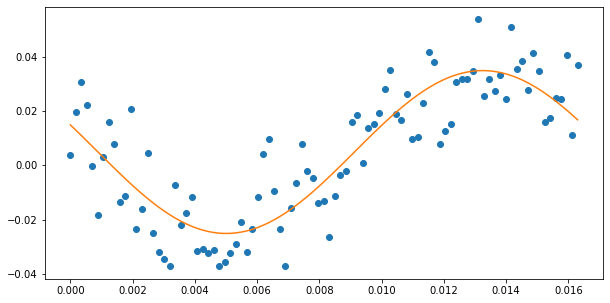

particle is:1
381.5177142972379
Storage modulus is:242.9328335376179
Loss modulus is:66.76534289569267
R^2: 0.653464064987042
[ 0.02463924  2.87338407 -0.01308368]


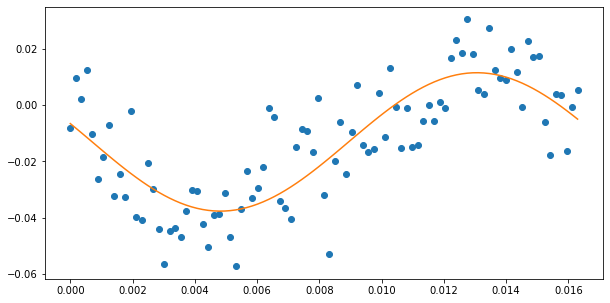

particle is:2
381.5177142972379
Storage modulus is:219.83989839932218
Loss modulus is:89.5075529077065
R^2: 0.6404732369268528
[ 2.61524340e-02  2.75493874e+00 -1.59494386e-03]


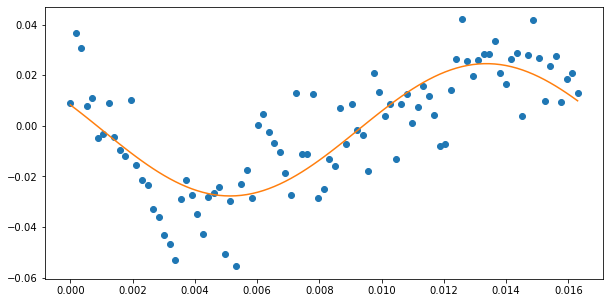

particle is:3
389.90271900706733
Storage modulus is:453.96105809264515
Loss modulus is:2.0159920759106116e-13
R^2: 0.4614548052735974
[ 0.01367434  3.14159265 -0.04318922]


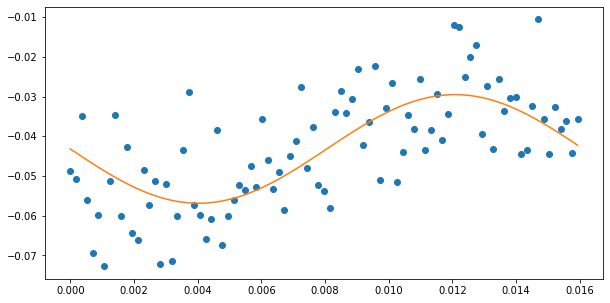

particle is:7
381.5177142972379
Storage modulus is:166.88911340744855
Loss modulus is:66.58016494155898
R^2: 0.8125998065988835
[0.0345482  2.76199305 0.01471865]


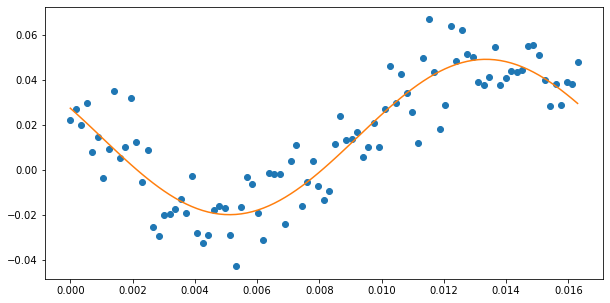

particle is:9
385.6646459743818
Storage modulus is:173.94267602772675
Loss modulus is:40.09387945120579
R^2: 0.795943034567111
[0.03477586 2.91504893 0.00792497]


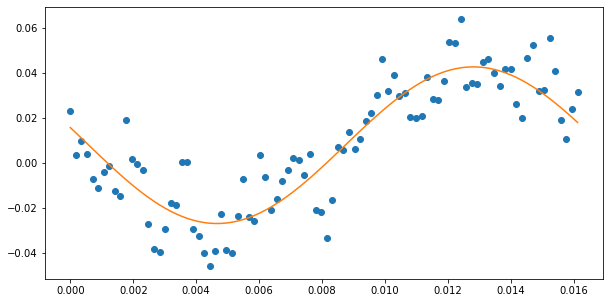

particle is:10
381.5177142972379
Storage modulus is:162.4816605285243
Loss modulus is:36.97283311287754
R^2: 0.8428557523107281
[0.03725276 2.91785165 0.00711631]


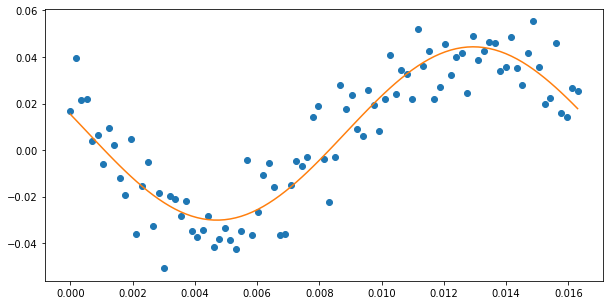

particle is:12
385.6646459743818
Storage modulus is:247.68847544806906
Loss modulus is:69.71586794640481
R^2: 0.7010054883564005
[0.0241248  2.86722511 0.00474521]


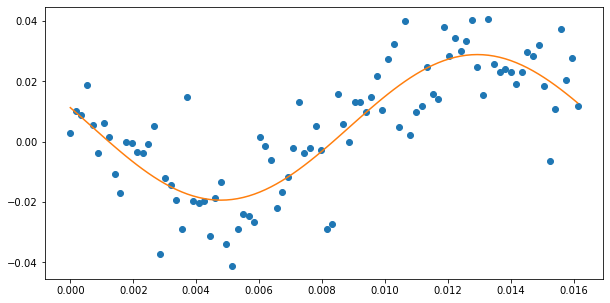

particle is:14
389.90271900706733
Storage modulus is:150.7395043907733
Loss modulus is:77.7824194458364
R^2: 0.6773357786006744
[ 0.03659622  2.66522275 -0.01166929]


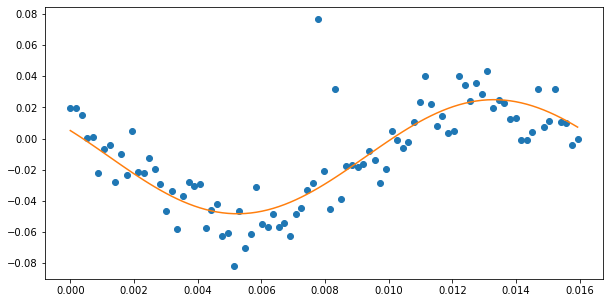

particle is:22
385.6646459743818
Storage modulus is:326.4178785772958
Loss modulus is:170.81455053900436
R^2: 0.48878916721527843
[ 0.01684974  2.65947908 -0.00950911]


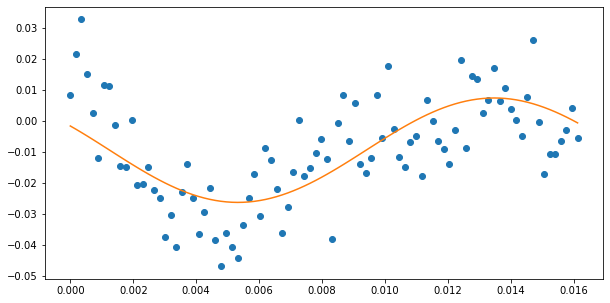

particle is:23
389.90271900706733
Storage modulus is:434.0794297737151
Loss modulus is:323.31041518295456
R^2: 0.10096432567226565
[0.01146898 2.50141592 0.03293601]


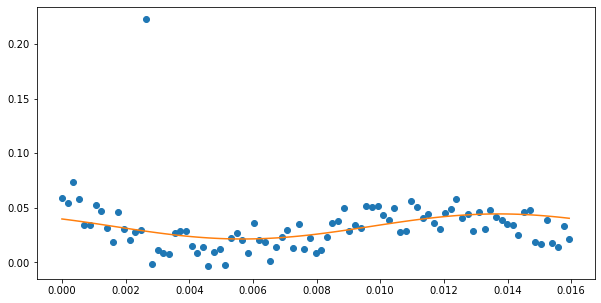

particle is:24
394.23497144047917
Storage modulus is:233.0176380707834
Loss modulus is:43.88681607040312
R^2: 0.727723172324159
[0.02617984 2.95543222 0.00779414]


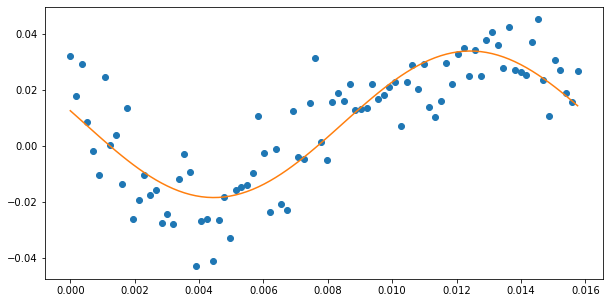

particle is:25
398.6645778611587
Storage modulus is:189.7439746305376
Loss modulus is:52.05553604818797
R^2: 0.8226789209695533
[0.03154999 2.87383439 0.01919835]


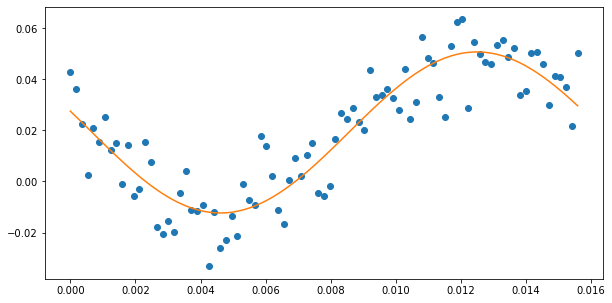

particle is:26
394.23497144047917
Storage modulus is:179.46104766188506
Loss modulus is:52.872715811744165
R^2: 0.7985875824098256
[0.03318027 2.85507942 0.00553428]


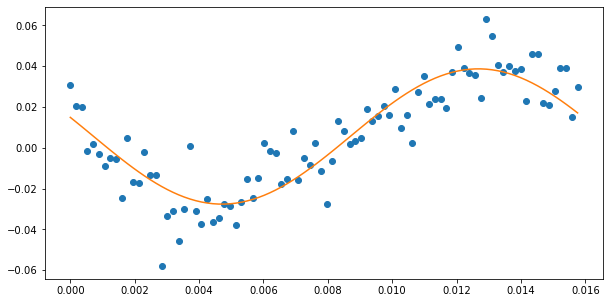

particle is:27
394.23497144047917
Storage modulus is:457.0346001760088
Loss modulus is:292.64748865959996
R^2: 0.3501847751105506
[ 0.0114384   2.57205389 -0.03278311]


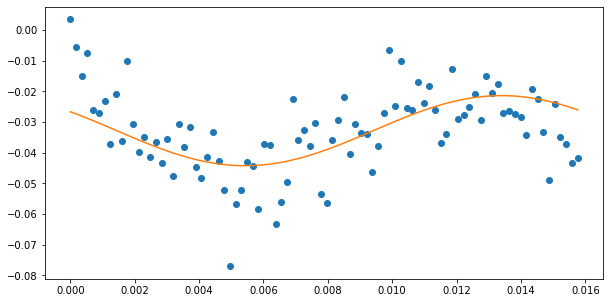

particle is:28
394.23497144047917
Storage modulus is:204.5892897903914
Loss modulus is:20.73320760831625
R^2: 0.7431960959975854
[3.01872456e-02 3.04059682e+00 2.58936722e-03]


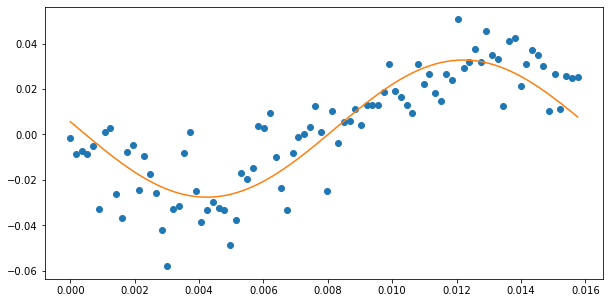

particle is:30
394.23497144047917
Storage modulus is:157.21619219965254
Loss modulus is:52.30870475212397
R^2: 0.8582152531591727
[ 0.03746529  2.82039573 -0.02132532]


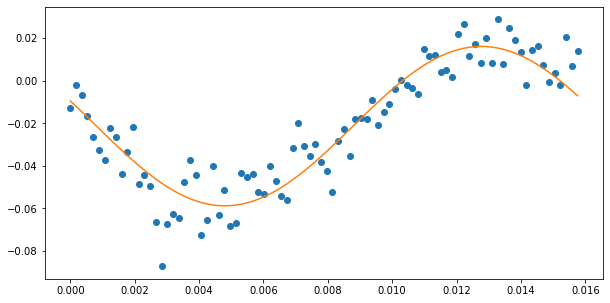

particle is:31
398.6645778611587
Storage modulus is:213.97874167916925
Loss modulus is:48.53243029713538
R^2: 0.7060036414227651
[0.02829187 2.91855649 0.00585966]


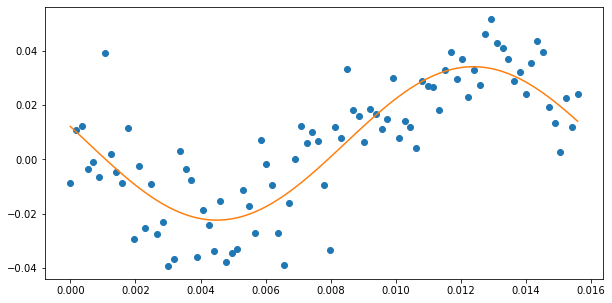

particle is:32
394.23497144047917
Storage modulus is:255.4048892835097
Loss modulus is:81.03781120100332
R^2: 0.6899370441758839
[ 0.02316683  2.83434851 -0.00963823]


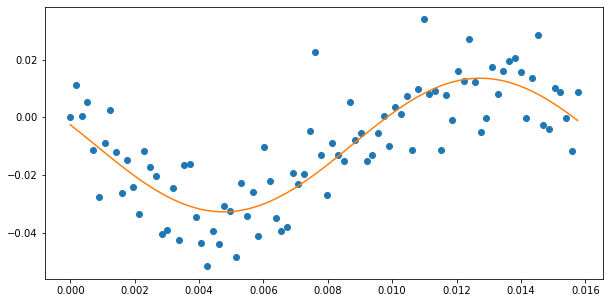

particle is:33
394.23497144047917
Storage modulus is:92.78126443531491
Loss modulus is:42.16266250803471
R^2: 0.8712733168554416
[ 0.06091157  2.7150602  -0.0237071 ]


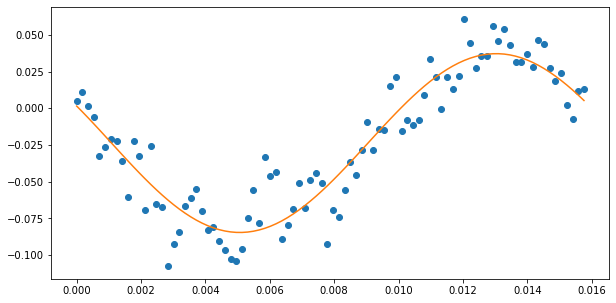

particle is:35
398.6645778611587
Storage modulus is:155.83818706236553
Loss modulus is:60.57945038317343
R^2: 0.8470328919089327
[ 0.0371272   2.77083676 -0.00590986]


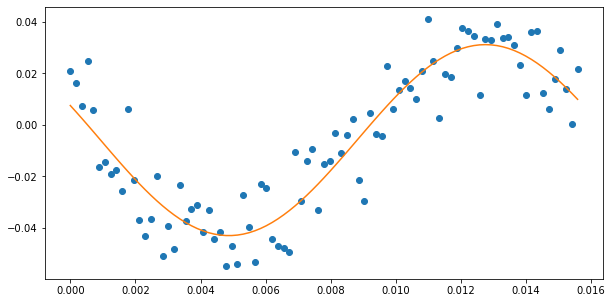

particle is:36
398.6645778611587
Storage modulus is:233.42139764303087
Loss modulus is:43.76192141200797
R^2: 0.7073643652718546
[ 0.02613864  2.9562637  -0.0042974 ]


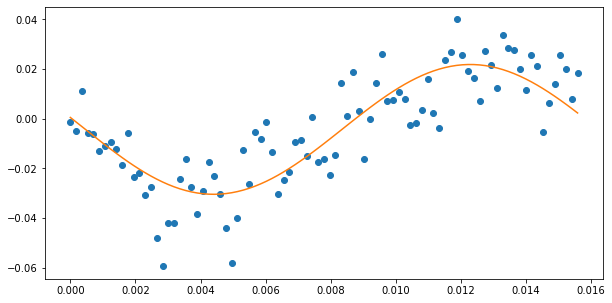

particle is:38
398.6645778611587
Storage modulus is:222.20821798294472
Loss modulus is:35.05380220126309
R^2: 0.7019252318357556
[0.0275948  2.98512999 0.0054324 ]


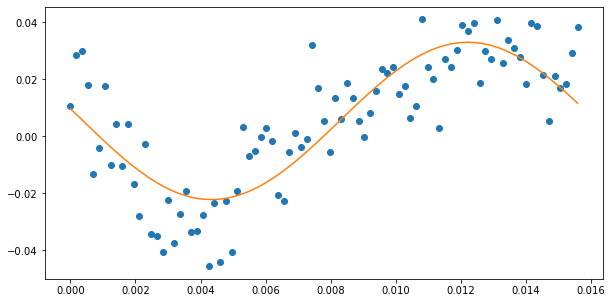

In [56]:
data2=utils.analyze_wavelength_modulus(wavelength2,gamma2list_w2,real_stress,framerate,imgname)

In [57]:
data2

,Droplet Number,Storage Modulus,Loss Modulus,Frequency,R^2,Video Name
0,0,195.180448,68.951924,381.517714,0.753633,0p5low_alg_12p5mM_3000ul_100um_20231012_102625...
4,7,166.889113,66.580165,381.517714,0.812600,0p5low_alg_12p5mM_3000ul_100um_20231012_102625...
5,9,173.942676,40.093879,385.664646,0.795943,0p5low_alg_12p5mM_3000ul_100um_20231012_102625...
6,10,162.481661,36.972833,381.517714,0.842856,0p5low_alg_12p5mM_3000ul_100um_20231012_102625...
12,25,189.743975,52.055536,398.664578,0.822679,0p5low_alg_12p5mM_3000ul_100um_20231012_102625...
13,26,179.461048,52.872716,394.234971,0.798588,0p5low_alg_12p5mM_3000ul_100um_20231012_102625...
16,30,157.216192,52.308705,394.234971,0.858215,0p5low_alg_12p5mM_3000ul_100um_20231012_102625...
19,33,92.781264,42.162663,394.234971,0.871273,0p5low_alg_12p5mM_3000ul_100um_20231012_102625...
20,35,155.838187,60.579450,398.664578,0.847033,0p5low_alg_12p5mM_3000ul_100um_20231012_102625...


# Concatenate

In [58]:
final_output = pd.concat([data1, data2], ignore_index=True)

In [59]:
final_output.to_csv('/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/results/102823_new.csv', index=False)